# Stratospheric Polar Vortex Diagnostics: A Comparison with Hannachi et al. (2011)
This notebook demonstrates the application of the *arctic* Python package to analyze the geometry and dynamics of the stratospheric polar vortex (SPV). It focuses on replicating and extending the methodology from Hannachi et al. (2011) using modern datasets and refined diagnostics.

# Table of Contents
- [Introduction](#introduction)
- [Data](#data)
    - [Differences to Hannachi et al. 2011](#differences-to-hannachi-et-al-2011)
- [Methodology](#methodology)
    - [Reconstruction of same conditions as H11](#reconstruction-of-same-conditions-as-h11)
    - [Scaling](#scaling)
    - [Seasonality](#seasonality)
        - [Durbin Watson Test](#durbin-watson-test)
        - [Autocorrelation Function](#autocorrelation-function)
        - [Singular Spectrum Analysis](#singular-spectrum-analysis)
        - [Extended Empirical Orthogonal Function](#extended-empirical-orthogonal-function)
    - [Gap statistic](#gap-statistic)
    - [Hierarchical clustering](#hierarchical-clustering)
- [Results](#results)
    - [Statistical Profiles of Clusters](#statistical-profiles-of-clusters)
    - [Physical Interpretation and Literature Comparison](#physical-interpretation-and-literature-comparison)
- [Appendix](#appendix)
    - [Partial Autocorrelation](#computation-of-the-partial-autocorrelation-function)
    - [Year over Year Averages](#year-over-year-averages)
    - [Abbreviations](#abbreviations)

# Introduction
The stratospheric polar vortex (SPV) plays a central role in modulating mid-latitude weather patterns, particularly during winter. Sudden stratospheric warming (SSW) events, which can split or displace the vortex, are of great interest due to their impacts on the troposphere.

This study builds upon the methodology of Hannachi et al. (2011, hereafter H11), who used geometric moments derived from potential vorticity fields to characterize vortex morphology. Here, we apply similar techniques to the extracted features from ERA5 reanalysis data. We aim to replicate and assess H11's clustering results using elliptic indices.

# Data
The data used in this study were provided and preprocessed by the Institute of Atmospheric Physics (IAP) in Kühlungsborn. The data includes daily diagnostics from ERA5 reanalysis, derived using the IDL-based ELDI and SSW package. Specifically, the dataset contains the daily elliptic indices of the stratospheric polar vortex at 10hPa geopotential height and major warming diagnostics.

The data are split into three files:

- `*_cen.csv`: Contains event-centered diagnostics, including central SSW dates, i.e. when the wind reversed from westerly to easterly, persistence, maximum eastward wind, intensity, and accumulated intensity.
- `*_msw.csv`: Flags daily major warming events with corresponding zonally averaged wind speed.
- `*_d.csv`: Includes daily geometric vortex diagnostics: area, centroid latitude/longitude (latcent, loncent), aspect ratio (ar), orientation angle (theta), and kurtosis. This file also marks split events (S) and includes diagnostics for identified sub-vortices, along with wave diagnostics at 60° latitude.

The ERA5 dataset spans 1963–2022. For reproducibility and demonstration, a reduced version is included for the demo notebook, containing only geometric moments and wind speed necessary for comparison with H11. Here, the full dataset will be processed, but is not included in the repository.

## Differences to Hannachi et al 2011
H11 initially used the following geometric moments: area, centroid latitude (latcent), aspect ratio (ar), and kurtosis. The latter was omitted due to the dominance of a few outliers. They derived moments from the ERA-40 reanalysis data at 850-K isentropic potential vorticity. In contrast, our data are based on 10hPa geopotential height, using the so called $Z10$ method, from the ERA5 reanalysis data. This methodological difference impacts the classification of vortex events. As Seviour et al. (2013) pointed out, the chosen method for moment calculation can substantially affect the frequency and classification of split vs. displacement events.

One key difference lies in the treatment of **seasonality**. H11 filtered out a ~120-day periodic signal found in the area data. This signal is absent in the ERA5-based geometric moments but reappears in wind speed, which is tied closely to the potential vorticity. To replicate the results from H11 as accurately as possible, the wind speed is used as a proxy for the area variable in H11 and as an indicator for the strength of a vortex.

In [4]:
# import vortexclust in general
import vortexclust

# import other important libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Import specific functions from vortexclust
from vortexclust.io.loader import read_data
from vortexclust.io.cleaner import no_white_space, to_date

# Read data
era5_d = read_data("../data/SWXClust/ERA5/e5e1_d.csv")
era5_cen = read_data("../data/SWXClust/ERA5/e5m1t-cen.csv")
era5_msw = read_data("../data/SWXClust/ERA5/e5m1t-msw.csv")

# Remove white space from column names
no_white_space(era5_d)
no_white_space(era5_cen)
no_white_space(era5_msw)

# Convert string to datetime for better comparison
to_date(era5_d, 'string', format='%d.%m.%Y-%H:%M:%S')
to_date(era5_cen, 'string', format='%d.%m.%Y-%H:%M')
to_date(era5_msw, 'string', format='%d.%m.%Y-%H:%M')

# Convert specified columns to numeric
col_convert = [
    'area1', 'obj_area1', 'latcent1', 'loncent1', 'theta1', 'ar1',
    'area2', 'obj_area2', 'latcent2', 'loncent2', 'theta2', 'ar2'
]
era5_d[col_convert] = era5_d[col_convert].apply(pd.to_numeric, errors='coerce')
era5_d = era5_d.fillna(0)

# Merge ERA5 data into one DataFrame
era5_all = era5_d.merge(era5_msw, on ='string', how='left', suffixes=[None, '_msw']).\
    merge(era5_cen, on='string', how='left', suffixes = ['_d', '_cen'])

# Handle categorical string encodings
from sklearn.preprocessing import LabelEncoder
le_mw = LabelEncoder()
era5_all['MW'] = le_mw.fit_transform(era5_all.MW)
print(f"Transformed 'MW':\n{le_mw.inverse_transform([1])} to 1\n{le_mw.inverse_transform([0])} to 0")
le_form = LabelEncoder()
era5_all['form'] = le_form.fit_transform(era5_all.form)
print(f"Transformed 'form': \n {le_form.inverse_transform([1])} to 1\n{le_form.inverse_transform([0])} to 0")

# Fill remaining NaNs in central diagnostics
era5_all[era5_cen.columns[-4:]] = era5_all[era5_cen.columns[-4:]].fillna(0)

# Drop constant or redundant columns
era5_all.drop(['D_d', 'level', 'hour',
               'D_cen', 'num', 'counter_cen', 'time_cen',
               'D_msw', 'counter_msw', 'time_msw'
               ], axis=1, inplace=True)
# Sort by date
era5_all = era5_all.sort_values('string').reset_index(drop=True)

# Check: Should be all non-null, all numeric or datetime
era5_all.info()

Transformed 'MW':
['MW'] to 1
[''] to 0
Transformed 'form': 
 ['S'] to 1
['D'] to 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21914 entries, 0 to 21913
Data columns (total 38 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   counter_d  21914 non-null  int64         
 1   time_d     21914 non-null  float64       
 2   string     21914 non-null  datetime64[ns]
 3   year       21914 non-null  int64         
 4   month      21914 non-null  int64         
 5   day        21914 non-null  int64         
 6   edge       21914 non-null  float64       
 7   form       21914 non-null  int64         
 8   area       21914 non-null  float64       
 9   obj_area   21914 non-null  float64       
 10  latcent    21914 non-null  float64       
 11  loncent    21914 non-null  float64       
 12  theta      21914 non-null  float64       
 13  ar         21914 non-null  float64       
 14  kurtosis   21914 non-null  float64       
 15  are

# Methodology
## Reconstruction of same conditions as H11
In H11, a winter period (December to March, DJFM) is selected, and data range from 1958 to 2002. The authors note activity peaks in December - January and an oscillation period around 120-130d. As mentioned earlier, the ERA5 data are only available from 1963 onward. In the following time series diagrams, this difference is marked by a dotted vertical line. Everything to the left of this line corresponds to the year shared with H11 and should therefore closely match the right part of their diagrams.

Due to the missing early data, there is a time shift of 516 days. This means, that day 484 in the diagrams below corresponds to day 1000 in H11. While this shift does not impact the structure of the time series, it must be taken into consideration when comparing specific event timings or pattern phases across the studies.

The diagrams illustrate the consecutive days of DJFM. To improve orientation and comparison to other studies, a second axis with the actual dates is added. However, since only winter months are shown, the timeline skips directly from March to December.

## Scaling
Normalization refers broadly to any transformation of data making them more compatible (Gewers et al., 2021). Common approaches include *MinMax* scaling, which maps each feature to a given range $\left[min, max\right]$, and *Standard* scaling, which transforms each variable to have a mean of zero and variance of one.

$$x' = \frac{x-\mu}{\sigma}$$

H11 does not explicitly state the applied scaling method. However, based on the timeseries diagrams in their study, Standard scaling appear likely. This is supported by the shape and spread of the rescaled features in the diagrams below.

## Time series of scaled AR, Latcent, Area and kurtosis
Due to the difference in data, the first 1000 days could not be reproduced as in H11. As noted above, the time shift is 516 days, which is illustrated by the dotted line in the diagrams.

It also remains is unclear in which order H11 performed scaling and DJFM selection. Scaling first, then selecting DJFM does result in different values than when proceeding vice versa. For example, when scaling is applied to the full year before selecting DJFM, the "baseline" of area appears to be slightly below zero. Based on visual comparison, it seems that H11 first filtered for DJFM and then scaled.

In [6]:
from sklearn.preprocessing import StandardScaler

# scale on entire data
sc = StandardScaler()
era5_all = era5_all[era5_all['string'] < pd.to_datetime('02-05-2006')] # buffer for filtering with eeof: 400days
era5_all.loc[:,['scaled_area', 'scaled_ar', 'scaled_latcent', 'scaled_kurtosis', 'scaled_u']] = sc.fit_transform(era5_all[['area', 'ar', 'latcent', 'kurtosis','u']])

# time constraints
era5_winter = era5_all[(era5_all['string'] < '03-15-2006') &
                     (era5_all['month']).isin([12,1,2,3])]
era5_winter.reset_index(drop=True, inplace=True)

# only geometric moments + wind speed
era5_hannachi = era5_winter[['string', 'year', 'month', 'day', 'area', 'ar', 'latcent', 'kurtosis', 'u']]
# scale on DJFM
era5_hannachi.loc[:, ['scaled_area', 'scaled_ar', 'scaled_latcent', 'scaled_kurtosis', 'scaled_u']] = sc.fit_transform(era5_hannachi[['area', 'ar', 'latcent', 'kurtosis', 'u']])

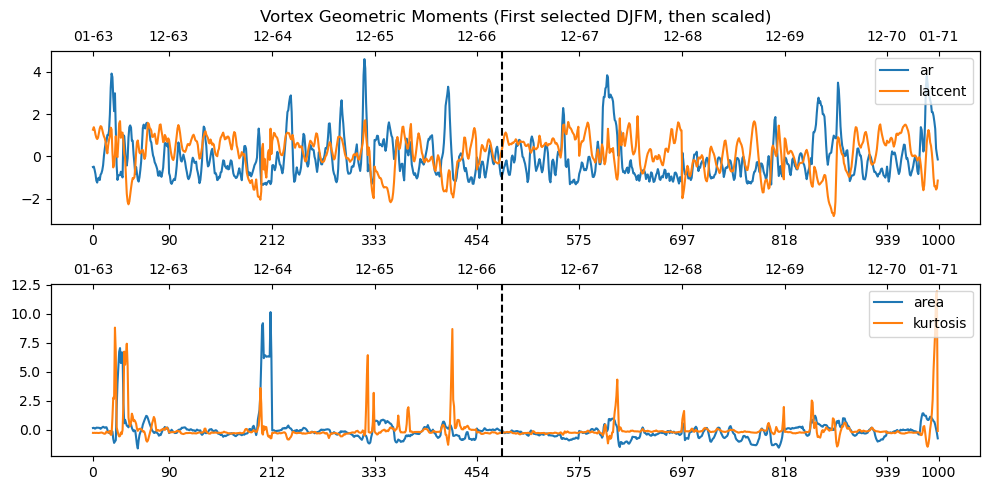

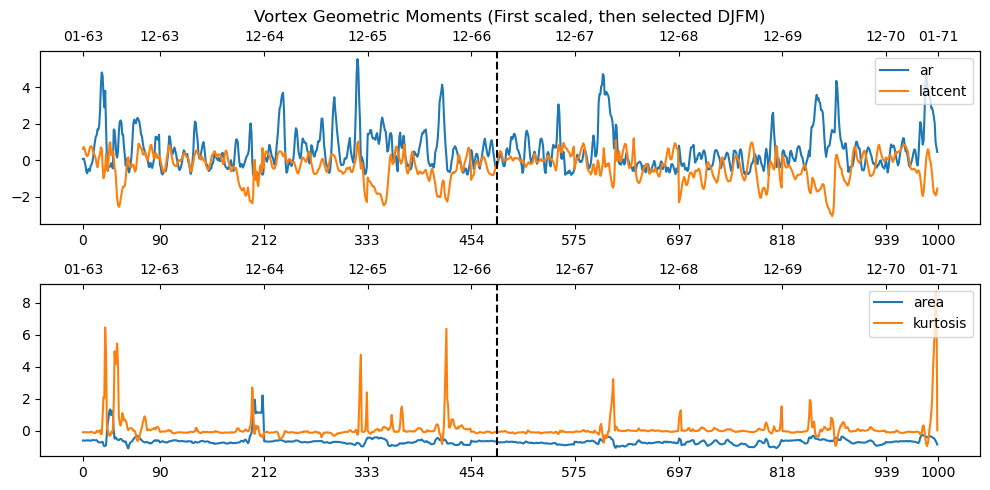

In [7]:
positions = [0]
positions[1: ] = [x for x in range(90, 1000, 121)]
positions[2:] = list(map(lambda x: x+1 , positions[2:]))
positions[6:] = list(map(lambda x: x+1 , positions[6:]))
positions.append(1000)

from vortexclust.workflows.demo import plot_timeseries_moments
plot_timeseries_moments(era5_hannachi,
                        ['scaled_ar', 'scaled_latcent', 'scaled_area', 'scaled_kurtosis'],
                        ['ar', 'latcent', 'area', 'kurtosis'],
                        title = 'Vortex Geometric Moments (First selected DJFM, then scaled)',
                        time_span=1000,
                        positions=positions,
                        vertical_line=484,
                        savefig='../output/scaled_moments.png')

plot_timeseries_moments(era5_winter,
                        ['scaled_ar', 'scaled_latcent', 'scaled_area', 'scaled_kurtosis'],
                        ['ar', 'latcent', 'area', 'kurtosis'],
                        title = 'Vortex Geometric Moments (First scaled, then selected DJFM)',
                        time_span=1000,
                        vertical_line=484,
                        positions=positions)

## Seasonality
Seasonality refers to recurring patterns or cycles in the data that occur at regular intervals. In climate data, such patterns are often driven by the solar cycle. For example, the stratospheric vortex builds due to a strong temperature gradient after the autumnal equinox and persists throughout the polar night. As polar day begins and the stratosphere warms, the polar vortex weakens and breaks down.

Neglecting seasonality can bias clustering results by grouping data points based on shared timeing rather than ib underlying physical characteristics. This is particularly problematic for clustering algorithms that are sensitive to the absolute distribution of the data and distances between samples. Removing or accounting for periodic signals ensures that resulting clusters represent true dynamical regimes of the vortex rather than artifacts of seasonality.

### Durbin-Watson Test
The Durbin-Watson test is used to detect the presence of first order autocorrelation in the residuals of a regression model. It assumes that:

- The residuals (errors) are normally distributed with a mean of 0
- The residuals are stationary over time

Commonly, it is interpretated as follows:
- **0 to 1.5**: strong **positive autocorrelation**
- **1.5 to 2.5**: little to **no autocorrelation**
- **2.5 to 4**: strong **negative autocorrelation**

In this analysis, the Durbin-Watson test indicates strong positive autocorrelation in the data, consistent with the findings of H11. This supports the presence of periodic signals in the data.

In [8]:
from statsmodels.stats.stattools import durbin_watson

# Check autocorrelation in scaled area
dw_area = durbin_watson(era5_hannachi['scaled_area'])
print(f"Durbin-Watson statistic on DJFM, then scaled area: {np.round(dw_area, 3)}")

# Check autocorrelation in scaled zonal wind speed
dw_u = durbin_watson(era5_hannachi['scaled_u'])
print(f"Durbin-Watson statistic on DJFM, then scaled wind speed: {np.round(dw_u, 3)}")

Durbin-Watson statistic on DJFM, then scaled area: 0.255
Durbin-Watson statistic on DJFM, then scaled wind speed: 0.036


### Autocorrelation function
To further investigate seasonality, the autocorrelation function (ACF) is used. The ACF measures how well a time series correlates with lagged versions of itself. It is defined at lag $k$ as follows

$$\rho_k = \frac{\mathrm{Cov}(x_t, x_{t-k})}{\sigma(x_t) \sigma(x_{t-k})}$$

In this analysis, the ACF is computed on unit vector normalized data. Importantly, scaling does not affect the shape of the autocorrelation, as it is inherently scale-invariant.

The dashed horizontal lines in the plots represent the 5% significance bounds of the ACF. Values of autocorrelation that lie above or below these bounds indicate statistically significant correlation at the corresponding lag.

⚠ For large lag values, ACF computation can become slow. It is recommended to use lags between 500 and 1500.

#### Interpretation
Both features show strong seasonal behaviour over the entire timeseries, which is to be expected from the formation and break down behaviour of the polar vortex.

The autocorrelation structure of the zonal wind speed (u) exhibits strong periodic behavior, with clear peaks at roughly 120-days lags. This indicates a strong periodic signal. This is consistent with the extremely low Durbin-Watson statistic (0.036), which confirms the presence of strong positive autocorrelation and long-range temporal dependence.

In contrast, the vortex area shows no pronounced periodicity in the autocorrelation function. Instead, it displays low-amplitude short-range fluctuations and a relatively fast decay of correlation. While the Durbin-Watson statistic for area (0.255) also indicates positive autocorrelation, it likely reflects smoother structural variability or low-frequency trends rather than a strictly seasonal signal.

These diagnostics support the application of deseasonalization techniques, such as SSA or EEOF, to wind speed prior to clustering. For geometric variables like area, no periodicity was found with the autocorrelation function. Hence, no deseasonalization is applied.

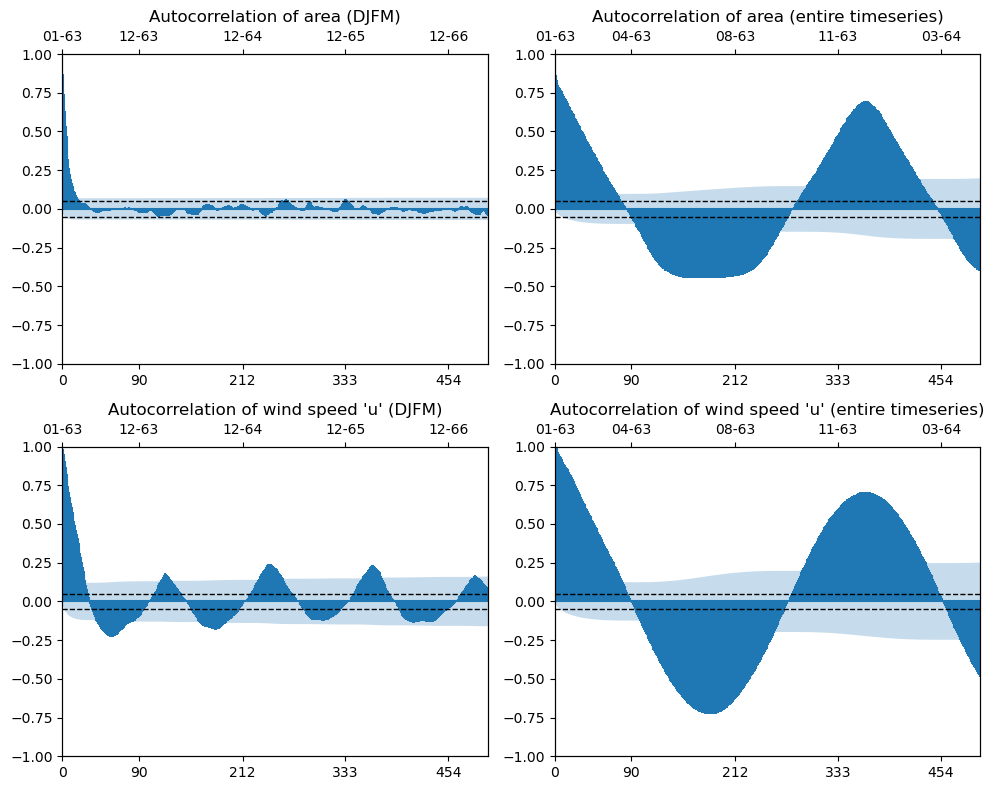

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(2,2, figsize=(10, 8))
ax = ax.flatten()

plot_acf(era5_hannachi['scaled_area'], lags=500, ax=ax[0],  marker=None)
plot_acf(era5_all['scaled_area'], lags=500, ax=ax[1], marker=None)

plot_acf(era5_winter['scaled_u'], lags=500, ax=ax[2], marker=None)
plot_acf(era5_all['scaled_u'], lags=500, ax=ax[3], marker = None)

ax[0].set_title('Autocorrelation of area (DJFM)')
ax[1].set_title('Autocorrelation of area (entire timeseries)')
ax[2].set_title("Autocorrelation of wind speed 'u' (DJFM)")
ax[3].set_title("Autocorrelation of wind speed 'u' (entire timeseries)")

for i in range(4):
    # 5% boundaries
    ax[i].axhline(y=0.05, linestyle='--', color='black', linewidth=1)
    ax[i].axhline(y=-0.05, linestyle='--', color='black', linewidth=1)
    # limit at lag
    ax[i].set_xlim(0, 500)
    # reset xticks to 120days period
    ax[i].set_xticks(positions[:5])
    ax[i].set_xticklabels([str(x) for x in positions[:5]])

    # set dates as second axis
    ax_top = ax[i].twiny()
    ax_top.set_xlim(ax[i].get_xlim())
    ax_top.set_xticks(positions[:5])
    if i%2 == 0:
        labels_dt = era5_hannachi.iloc[positions[:5]]['string'].dt.strftime("%m-%y")
    else:
        labels_dt = era5_all.iloc[positions[:5]]['string'].dt.strftime("%m-%y")
    ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)

plt.tight_layout()
plt.savefig('../output/acf.png')
plt.show()

p### Singular Spectrum Analysis

Singular Spectrum Analysis (SSA) is a non-parametric spectral decomposition method that can be understood as applying singular value decomposition (SVD) to a lagged embedding of a time series. The original univariate time series is first transformed into a multivariate series via delay embedding, using a sliding window of length $M$.

The choice of window length $M$ is critical: larger values allow for finer decomposition, but for periodic signals, $M$ should not exceed the dominant period to avoid over-smoothing or leakage. Once the embedding is constructed, SVD is applied to extract principal components (eigenvectors) that represent the dominant patterns or oscillatory modes within the time series.

The original signal can then be reconstructed as a sum of selected components, allowing separation of trend, oscillatory, and noise-like behavior.

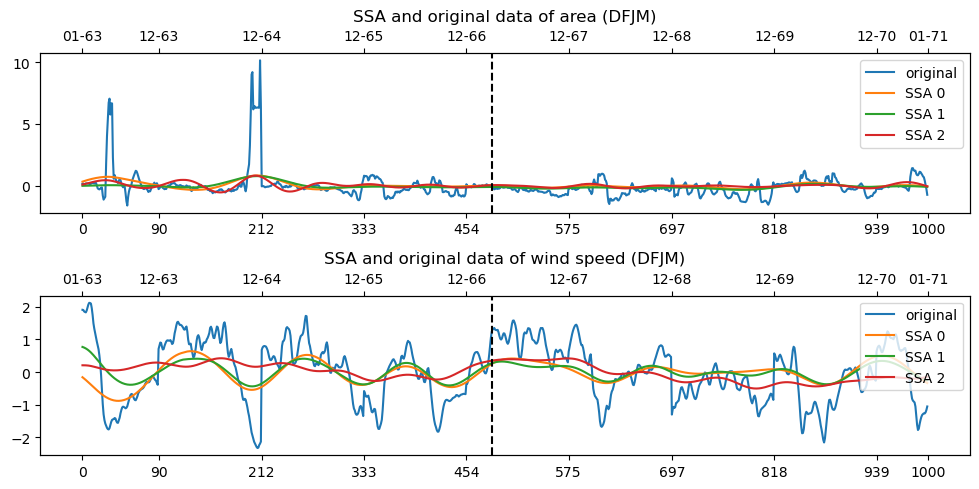

In [14]:
from pyts.decomposition import SingularSpectrumAnalysis

M = 120
ssa = SingularSpectrumAnalysis(window_size=M)
ssa_area = ssa.fit_transform(era5_hannachi['scaled_area'].values.reshape(1, -1))
ssa_u = ssa.fit_transform(era5_hannachi['scaled_u'].values.reshape(1, -1))

fig, axes = plt.subplots(2, figsize=(10, 5))
axes[0].set_title('SSA and original data of area (DFJM)')
axes[1].set_title('SSA and original data of wind speed (DFJM)')
axes[0].plot(era5_hannachi['scaled_area'][:1000], label='original')
axes[1].plot(era5_hannachi['scaled_u'][:1000], label='original')
for i in range(3):
    axes[0].plot(ssa_area[i, :1000], label=f"SSA {i}")
    axes[1].plot(ssa_u[i, :1000], label=f"SSA {i}")
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')
for i in range(2):
    # set dates as second axis
    ax_top = axes[i].twiny()
    ax_top.set_xlim(axes[i].get_xlim())
    ax_top.set_xticks(positions)
    axes[i].set_xticks(positions)
    labels_dt = era5_hannachi.iloc[positions]['string'].dt.strftime("%m-%y")
    ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)
    axes[i].axvline(x=484, color='black', linestyle='--')

plt.tight_layout()
plt.show()

### Extended Empirical Orthogonal Function
The Extended Empirical Orthogonal Function (EEOF/EOF) is an extension of the standard EOF analysis, adapted for spatiotemporal data. Like SSA, EEOF decomposes time series into orthogonal components, but it does so across multiple correlated variables or spatial locations, incorporating lagged temporal information into each observation vector. This makes EEOF especially well suited for capturing propagating modes and phase relationsships between variables.

In the EEOF framework, the data matrix is constructed by stacking lagged versions of each variable (or spatial point), producing a higher-dimensional trajectory matrix. A singular value decomposition (SVD) is then performed to extract the dominant orthogonal modes. These modes can be interpreted as coherent structures in space-time and used for reconstruction, filtering, or dimensionality reduction prior to clustering or regression.

In the implementation below, EEOF decomposition is applied to the scaled DJFM time series of zonal wind speed and vortex area. A lag window of 400 days is selected, which captures multiple full seasonal cycles and is suitable for identifying low-frequency variability. The first 30 principal components are extracted. The explained variance ratio provides insight into the relative importance of each component, while the reconstructed signals can be used for seasonality filtering or further dynamical interpretation. Plotting the EEOF and the Empirical Principle Components (EPCs) over time as well as their phase diagram, gives insight into in the stability of the periodic signal.

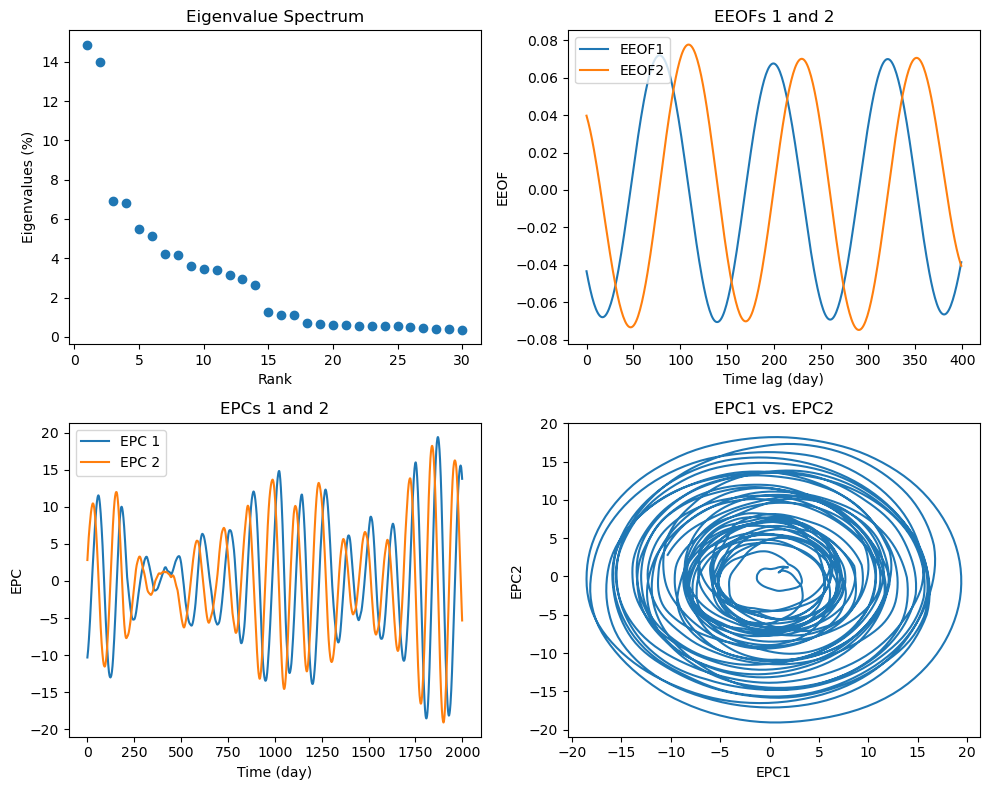

The EEOF evaluation for area based on ERA5 reanalysis data.


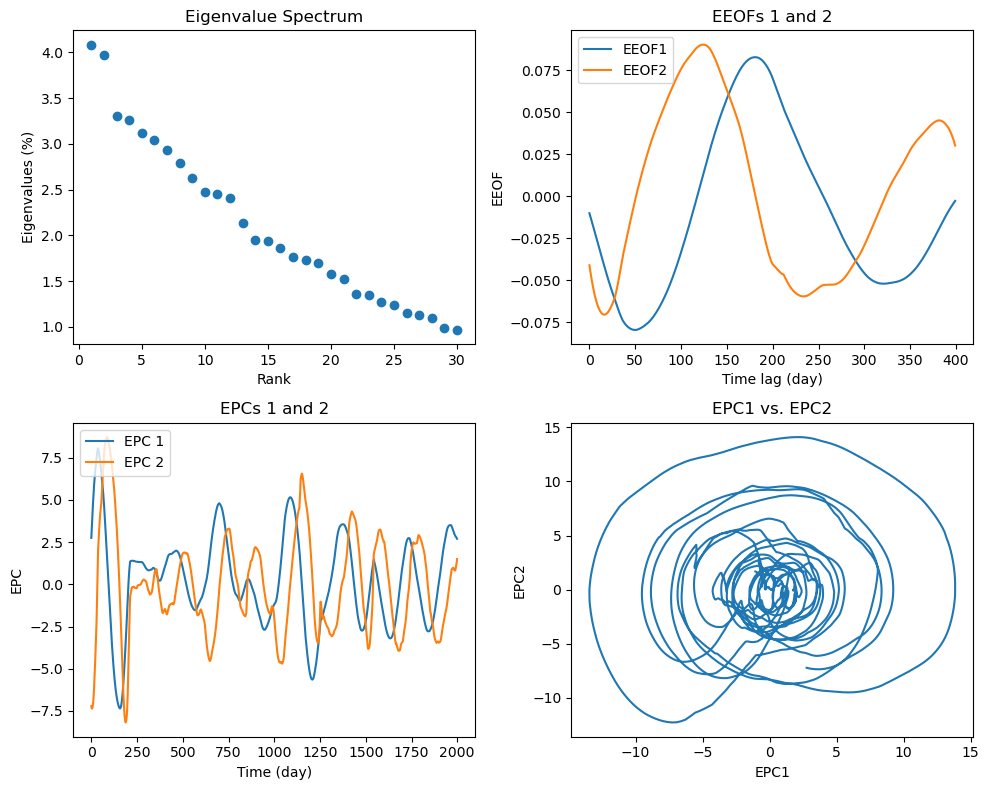

In [15]:
epc_u, eeof_u, expl_var_ratio_u, reconstructed_u, _ = vortexclust.compute_eeof(era5_hannachi['scaled_u'], M=400, n_components=30)
epc_area, eeof_area, expl_var_ratio_area, reconstructed_area, _ = vortexclust.compute_eeof(era5_hannachi['scaled_area'], M=400, n_components=30)

from vortexclust.workflows.demo import plot_eeof
plot_eeof(epc_u, eeof_u, expl_var_ratio_u, "../output/eeof_u.png")
print('The EEOF evaluation for area based on ERA5 reanalysis data.')
plot_eeof(epc_area, eeof_area, expl_var_ratio_area)

### Filtering

To isolate and remove the dominant periodic signal, the time series is reconstructed using a reduced number of components. H11 selected the four leading extended principal components (EPCs) from the EEOF decomposition for this purpose. The reconstructed signal approximates the 120day cycle, which is then subtracted from the original data to yield a deseasonalized time series.

Below, the reconstruction using the four leading EPCs is compared with reconstructions based on SSA components, as well as with reconstructions using 2, 4, and 30 components for both methods. It becomes evident that including too many components leads to near-perfect reconstruction of the original signal. As a result, little to no structure remains in the residual, essentially removing both signal and noise. To avoid this overfitting and to remain consistent with H11, we proceed using the first four components.

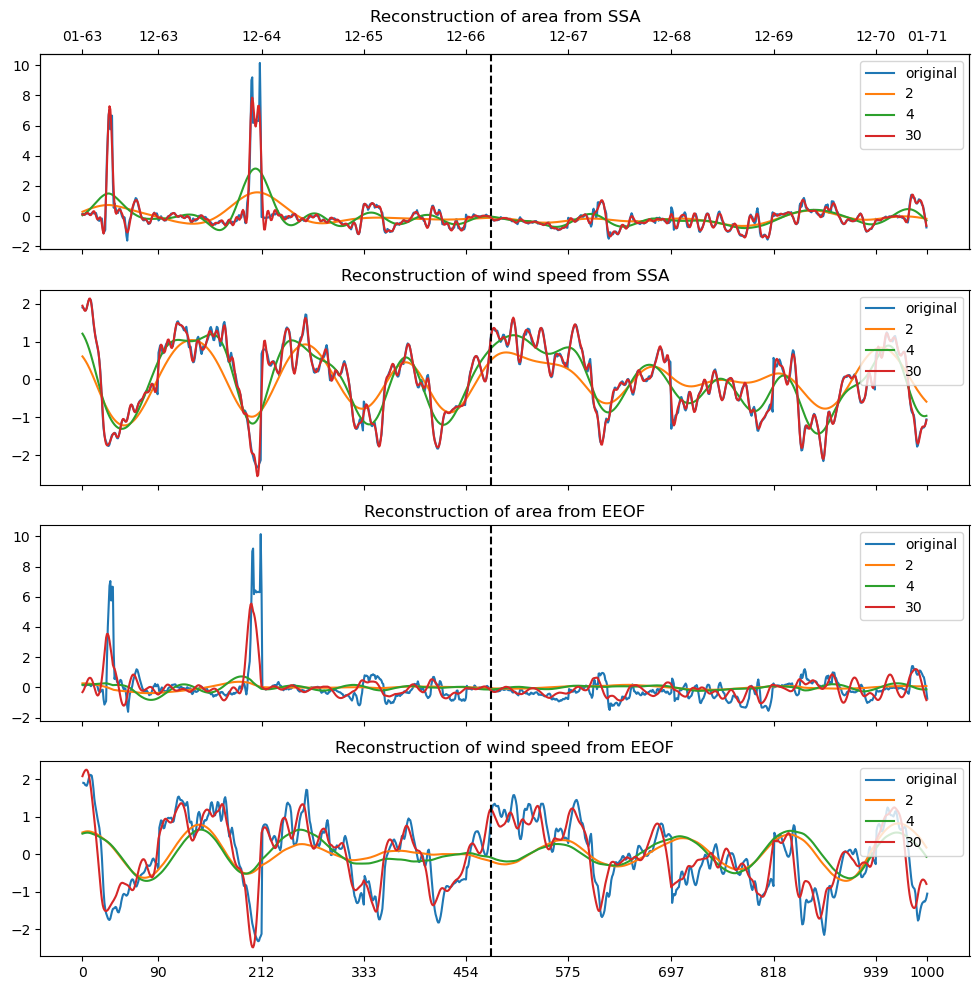

In [16]:
fig, ax = plt.subplots(4, figsize=(10, 10), sharex='all')

ax[0].set_title('Reconstruction of area from SSA')
ax[1].set_title("Reconstruction of wind speed from SSA")
ax[2].set_title('Reconstruction of area from EEOF')
ax[3].set_title("Reconstruction of wind speed from EEOF")

ax[0].plot(era5_hannachi['scaled_area'][:1000], label='original')
ax[1].plot(era5_hannachi['scaled_u'][:1000], label='original')
ax[2].plot(np.arange(1, 1001), era5_hannachi['scaled_area'][:1000], label='original')
ax[3].plot(np.arange(1, 1001), era5_hannachi['scaled_u'][:1000], label='original')
for i in [2, 4, 30]:
    ssa_reconstructed_area = ssa_area[:i].sum(axis = 0)
    ssa_reconstructed_u = ssa_u[:i].sum(axis=0)
    _, _, _, eeof_reconstructed_area, _ = vortexclust.compute_eeof(era5_hannachi['scaled_area'], M=400, n_components=i)
    _, _, _, eeof_reconstructed_u, _ = vortexclust.compute_eeof(era5_hannachi['scaled_u'], M=400, n_components=i)
    ax[0].plot(ssa_reconstructed_area[:1000], label=f"{i}")
    ax[1].plot(ssa_reconstructed_u[:1000], label=f"{i}")
    ax[2].plot(eeof_reconstructed_area[399:1399, 0], label=f"{i}")
    ax[3].plot(eeof_reconstructed_u[399:1399, 0], label=f"{i}")

for i in range(4):
    ax[i].legend(loc='upper right')
    ax[i].axvline(x=484, color='black', linestyle='--')
# set dates as second axis
ax_top = ax[0].twiny()
ax_top.set_xlim(ax[0].get_xlim())
ax_top.set_xticks(positions)
ax[0].set_xticks(positions)
labels_dt = era5_hannachi.iloc[positions]['string'].dt.strftime("%m-%y")
ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)
plt.tight_layout()
plt.show()

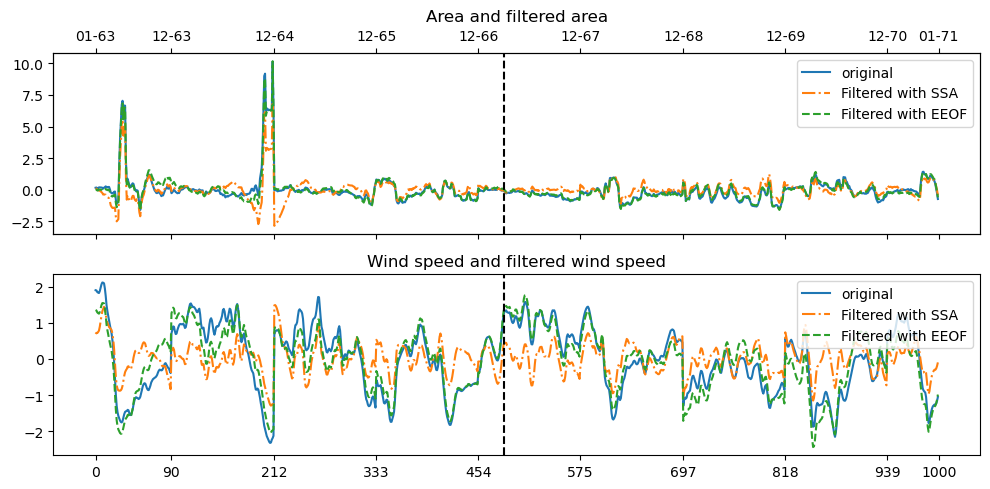

In [17]:
# Compute eeof with respective number of components
_, _, _, eeof_reconstructed_area, _ = vortexclust.compute_eeof(era5_hannachi['scaled_area'], M=400, n_components=4)
_, _, _, eeof_reconstructed_u, _ = vortexclust.compute_eeof(era5_hannachi['scaled_u'], M=400, n_components=4)

# Reduce data to match the time conditions in H11 (1958 to 2002)
era5_hannachi = era5_hannachi[era5_hannachi['string'] < '01-01-2003']

# Subtract reconstructed seasonal signal (first 4 components)
era5_hannachi['ssa_filtered_area'] = era5_hannachi['scaled_area'] - ssa_area[:4, :era5_hannachi.shape[0]].sum(axis = 0).T
era5_hannachi['ssa_filtered_u'] = era5_hannachi['scaled_u'] - ssa_u[:4, :era5_hannachi.shape[0]].sum(axis=0).T
era5_hannachi['eeof_filtered_area'] = era5_hannachi['scaled_area'] - eeof_reconstructed_area[399:, 0].T
era5_hannachi['eeof_filtered_u'] = era5_hannachi['scaled_u'] - eeof_reconstructed_u[399:, 0].T

fig, ax = plt.subplots(2, figsize=(10, 5), sharex='all')
ax[0].set_title('Area and filtered area')
ax[0].plot(era5_hannachi['scaled_area'][:1000], label='original')
ax[0].plot(era5_hannachi['ssa_filtered_area'][:1000], '-.', label='Filtered with SSA')
ax[0].plot(era5_hannachi['eeof_filtered_area'][:1000], '--', label='Filtered with EEOF')
ax[1].set_title('Wind speed and filtered wind speed')
ax[1].plot(era5_hannachi['scaled_u'][:1000], label='original')
ax[1].plot(era5_hannachi['ssa_filtered_u'][:1000], '-.', label='Filtered with SSA')
ax[1].plot(era5_hannachi['eeof_filtered_u'][:1000], '--', label='Filtered with EEOF')

for i in range(2):
    ax[i].legend(loc='upper right')
    ax[i].axvline(x=484, color='black', linestyle='--')
# set dates as second axis
ax_top = ax[0].twiny()
ax_top.set_xlim(ax[0].get_xlim())
ax_top.set_xticks(positions)
ax[0].set_xticks(positions)
labels_dt = era5_hannachi.iloc[positions]['string'].dt.strftime("%m-%y")
ax_top.set_xticklabels(labels_dt, ha='center', rotation=0)
plt.tight_layout()
plt.savefig("../output/ssa_eeof_era5.png")
plt.show()

## Gap statistic
The performance of clustering algorithm depends severely on the right number of clusters as input. Determining the optimal number of cluster $k_{opt}$ is nontrivial, and fitting models is computationally expensive. Hence, more elegant ways than simply testing different $k$ are required. Further unsupervised clustering has no notion of wrong or right, but requires different measures to evaluate a models quality. Most techniques define a measure of similarity, which should be maximized in clusters and minimized between clusters. Consequently, dissimilarity is defined vice versa. Then the similarity or dissimilarity is compared for different values of $k$.

The gap statistic introduced by Tibshirani et al. (2001) bases on the idea to compare the within cluster dispersion of the actual data to a null reference distribution. The null reference is typically generated by a homogeneous Poisson point process (HPPP).

To compute the within cluster dispersion, the pairwise squared distances between all data points in a cluster $C_m, m=1, ..., k$ are computed by

$$D_m = \sum_{i,j \in C_m} \|x_i- x_j\|^2 = 2n_m \sum_{i=1}^{n_m} \|x_i- \mu_m\|^2$$

with $|C_m| = n_m$ being the size of the $m$th cluster. Note that this assumes Euclidean geometry and unweighted samples.

Some implementations use the distance $\|x_i - c_m\|$, i.e. the distance of a data point $x_i$ to its corresponding cluster center $c_m=\mu_m$. This is only applicable in clustering algorithms that have some notion of centers such as k-means. For clustering methods without such centers, such as hierarchical clustering, the gap statistic is more precise using the above notation instead of calculating centers manually.

In the next step, $D_m$ is averaged to obtain the overall dispersion index $W_k$.
$$W_k = \sum_{m=1}^{k} \frac{D_m}{2n_m}$$
The sum of squared distances to the center of a cluster is the same as $W_k$ as long there are no sample weights.

Finally, the gap statistic for each $k$ is computed by the difference between the *within dispersion index* of the data, $log(W_k)$,  and that expected from the generated reference $log(W_k^*)$.
$$G(k) = E[log(W_k^*)] - log(W_k)$$

Here, $E(\cdot)$ is the expectation as usually defined. A Monte Carlo simulation generates $N$ samples of $log(W_k^*)$, where each $W_k^*$ is based on the same number of points as the original data. Additionally, the standard deviation $s_k^*$ is computed and used to account for the simulation error in $E[log(W_k^*)]$ with the inflated standard deviation $s_k = s_k^*\sqrt{1+\frac{1}{N}}$. Finally, the optimal $k_{opt}$ is determined by the smallest $k$ such that

$$
	G(k) \geq G(k+1) - s_{k+1}
$$

Tibshirani et al. demonstrated that the gap statistic is a robust method for estimating the number of clusters. Their findings indicate that, for elongated clusters, the gap statistic yields better results with a null reference aligned to the data's principal components. In contrast, using a simple uniform distribution leads to inferior results. Overall, the underlying distribution of data does not influence the results of the gap statistic, making it more robust than other methods.

The performance of the gap statistic deteriorates in high-dimensional settings due to computational costs. It is also prone to underestimation the optimal $k$ in settings with many clusters. The underestimation vanishes with increasing dimensionality.

H11 focused primarily on the gap statistic. In the analysis below, it is applied alongside the **elbow** and **silhouette** methods for comparison.

## Hierarchical Clustering
Hierarchical clustering is a family of clustering methods that focuses on building nested clusters. This is achieved by merging or splitting them successively. The hierarchy can be represented in a so-called dendrogram, i.e. a tree, where the root contains all samples and each leaf represents a samples. Leaves next to each other correspond to similar samples. H11 does not specify the precise algorithm, so agglomorative clustering is applied here as an adaption.

Agglomerative clustering uses a bottom up approach, i.e. each sample starts as its own cluster and is successively merged with the nearest cluster. The mergingn criterion is defined by a linkage method, which determines how distances between clusters are computed. The default is $complete$ as determined in H11 to prevent spheroidal or elongated (chained) clusters and distance means the Euclidean distance. Below an overview of some linkage methods is given.

|               | between points in Cluster | to different clusters                      |
|---------------|---------------------------|--------------------------------------------|
| Closest       | Single Linkage            | Centroid Linkage                           |
| Most Distance | **Complete Linkage**      | Average Linkage (Average of all distances) |

Due to the computational intensity of model fitting and validation, the following code cells may require several minutes to complete.

In [18]:
k_max = 10
gap_ar_latcent = vortexclust.gap_statistic(era5_hannachi[['scaled_ar', 'scaled_latcent']], k_max=k_max, n_replicates=15)
gap_ar_latcent_area = vortexclust.gap_statistic(era5_hannachi[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max, n_replicates=15)
gap_ar_latcent_filteredssa = vortexclust.gap_statistic(era5_hannachi[['scaled_ar', 'scaled_latcent', 'ssa_filtered_area']], k_max=k_max, n_replicates=15)
gap_ar_latcent_u = vortexclust.gap_statistic(era5_hannachi[['scaled_ar', 'scaled_latcent', 'ssa_filtered_u']], k_max=k_max, n_replicates=15)

In [19]:
elbow_ar_latcent = vortexclust.elbow_method(era5_hannachi[['scaled_ar', 'scaled_latcent']], k_max=k_max)
elbow_ar_latcent_area = vortexclust.elbow_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max)
elbow_ar_latcent_filteredssa = vortexclust.elbow_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'ssa_filtered_area']], k_max=k_max)
elbow_ar_latcent_u = vortexclust.elbow_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'ssa_filtered_u']], k_max=k_max)

In [20]:
silhouette_ar_latcent = vortexclust.silhouette_method(era5_hannachi[['scaled_ar', 'scaled_latcent']], k_max=k_max)
silhouette_ar_latcent_area = vortexclust.silhouette_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'scaled_area']], k_max=k_max)
silhouette_ar_latcent_filteredssa = vortexclust.silhouette_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'ssa_filtered_area']], k_max=k_max)
silhouette_ar_latcent_u = vortexclust.silhouette_method(era5_hannachi[['scaled_ar', 'scaled_latcent', 'ssa_filtered_u']], k_max=k_max)

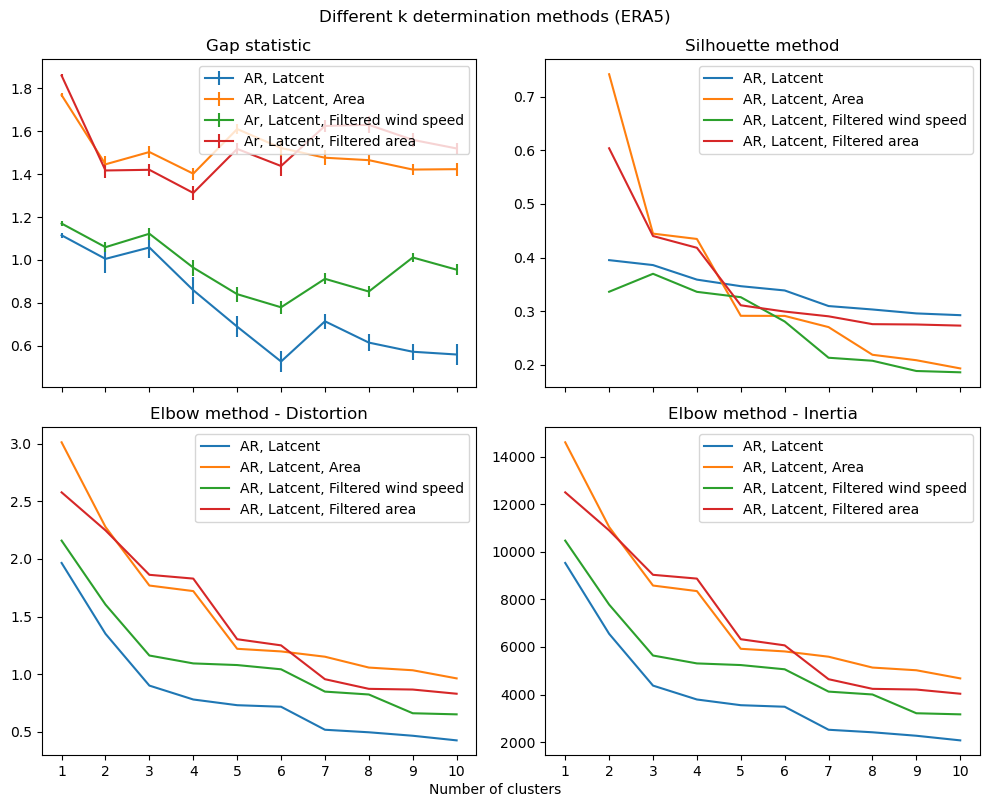

In [21]:
fig, ax = plt.subplots(2,2, figsize=(10, 8), sharex='all')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent[:, 0], yerr=gap_ar_latcent[:, 1], label='AR, Latcent')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent_area[:, 0], yerr=gap_ar_latcent_area[:, 1], label='AR, Latcent, Area')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent_u[:, 0], yerr=gap_ar_latcent_u[:, 1], label='Ar, Latcent, Filtered wind speed')
ax[0][0].errorbar(np.arange(1,k_max+1), gap_ar_latcent_filteredssa[:, 0], yerr=gap_ar_latcent_filteredssa[:, 1], label='Ar, Latcent, Filtered area')
ax[0][0].set_title('Gap statistic')
ax[0][0].legend(loc='upper right')

ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent[0], label='AR, Latcent')
ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent_area[0], label='AR, Latcent, Area')
ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent_u[0], label='AR, Latcent, Filtered wind speed')
ax[1][0].plot(np.arange(1,k_max+1), elbow_ar_latcent_filteredssa[0], label='AR, Latcent, Filtered area')
ax[1][0].set_title('Elbow method - Distortion')
ax[1][0].legend(loc='upper right')

ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent[1], label='AR, Latcent')
ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent_area[1], label='AR, Latcent, Area')
ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent_u[1], label='AR, Latcent, Filtered wind speed')
ax[1][1].plot(np.arange(1,k_max+1), elbow_ar_latcent_filteredssa[1], label='AR, Latcent, Filtered area')
ax[1][1].set_title('Elbow method - Inertia')
ax[1][1].legend(loc='upper right')

ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent, label='AR, Latcent')
ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent_area, label='AR, Latcent, Area')
ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent_u, label='AR, Latcent, Filtered wind speed')
ax[0][1].plot(np.arange(2,k_max+1), silhouette_ar_latcent_filteredssa, label='AR, Latcent, Filtered area')
ax[0][1].set_title('Silhouette method')
ax[0][1].legend(loc='upper right')

plt.suptitle('Different k determination methods (ERA5)')
plt.xticks(np.arange(1, k_max+1))
fig.text(0.5, 0, 'Number of clusters', ha='center')
plt.tight_layout()
plt.savefig('../output/Kopt_era5.png')
plt.show()

In [22]:
print("Optimal number of clusters by each method: ")
p_1, p_2, p_3, p_4 = 1,1,1,1
for k in range(1, 10):
    if p_1 and (gap_ar_latcent[k][0] >= gap_ar_latcent[k+1][0] - gap_ar_latcent[k+1][1]):
        print('Gap statistic (AR, Latcent): ', k+1) # index starts at 0, k starts at 1
        p_1=0
    if p_2 and (gap_ar_latcent_area[k][0] >= gap_ar_latcent_area[k+1][0] - gap_ar_latcent_area[k+1][1]):
        print("Gap statistic (AR, Latcent, Area): ", k+1)
        p_2 = 0
    if p_4 and (gap_ar_latcent_filteredssa[k][0] >= gap_ar_latcent_filteredssa[k+1][0] - gap_ar_latcent_filteredssa[k+1][1]):
        print("Gap statistic (AR, Latcent, SSA filtered Area): ", k+1)
        p_4 = 0
    if p_3 and (gap_ar_latcent_u[k][0] >= gap_ar_latcent_u[k+1][0] - gap_ar_latcent_u[k+1][1]):
        print("Gap statistic (AR, Latcent, filtered wind speed): ", k+1)
        p_3=0

print("Silhouette method (AR, Latcent): ", pd.DataFrame(silhouette_ar_latcent).idxmax()[0]+2)
print("Silhouette method (AR, latcent, Area): ", pd.DataFrame(silhouette_ar_latcent_area).idxmax()[0]+2)
print("Silhouette method (AR, latcent, filtered Area): ", pd.DataFrame(silhouette_ar_latcent_filteredssa).idxmax()[0]+2)
print("Silhouette method (AR, latcent, filtered wind speed): ", pd.DataFrame(silhouette_ar_latcent_u).idxmax()[0]+2)

Optimal number of clusters by each method: 
Gap statistic (AR, Latcent, SSA filtered Area):  2
Gap statistic (AR, Latcent):  3
Gap statistic (AR, Latcent, Area):  3
Gap statistic (AR, Latcent, filtered wind speed):  3
Silhouette method (AR, Latcent):  2
Silhouette method (AR, latcent, Area):  2
Silhouette method (AR, latcent, filtered Area):  2
Silhouette method (AR, latcent, filtered wind speed):  3


### Optimal number of clusters
The gap statistic suggests that the data lacks a strong intrinsic cluster structure, consistently favoring $k=1$. The silhouette method partially supports this interpretation.

However, when restricting the evaluation to $k > 1$, all three methods identify $k_{opt} = 3$ when clustering based on ar and latcent, or ar, latcent and filtered wind speed. The wind speed serves as a proxy for the area used in H11, capturing its seasonal behaviour.

In contrast, incorporating the area computed from the $Z10$ method leads to ambiguity. The gap statistic and silhouette method both indicate weak clustering tendencies. Nonetheless, the gap statistic has a local maxima at $k=3$ and $k=5$. And another at $k=7$ when the area is filtered. It is a known limitation of the gap statistic that it tends to select the first local maxima as optimal $k$, potentially underestimating the true optimal number of clusters. The silhouette method shows sharp breaks at $k=3$ and $k=5$ indicating potential regime separations. A similar behaviour can be observed in the elbow method. Tough even $k=7$ could be argued for with the elbow method.

Summary of $k_{opt}$ by feature set and method:

| Used features              | Gap statistic | Silhouette  | Elbow (Distortion) | Elbow (Inertia) |
|----------------------------|---------------|-------------|--------------------|-----------------|
| AR, latcent                | 1 or 3        | 2           | 3                  | 3               |
| AR, latcent, wind speed    | 1 or 3        | 3           | 3                  | 3               |
| AR, latcent, area          | 1 or 3 or 5   | 2 or 3 or 5 | 3 or 5             | 3 or 5          |
| AR, latcent, filtered area | 1 or 5 or 7   | 3           | 3 or 5             | 3 or 5          |


#### Possible reasons for differences to H11
- different data source: H11 used ERA-40 data, whereas ERA5 is used here. Hierarchical clustering is highly sensitive to the precise data distribution.
- different feature extraction: H11 computed the area from 850K potential vorticity; this study uses the geometric diagnostics computed from the geopotential height.
- different preprocessing: Although standard scaling was likely used in both cases, minor distributional shifts may affect absolute magnitudes.
- no autocorrelation in area: Filtering may remove meaningful structure from the area variable, weakening its contribution to clustering.
- wind speed as areaf proxy: Wind speed reflects the dynamical evolution captured in potential vorticity, supporting its use as a stand-in for the original area metric.

For the remainder of the analysis $k_{opt} = 3$ is adopted, based on convergence of the elbow method, gap statistic and silhouette method for clustering based on ar, latcent and wind speed and as determined by H11.

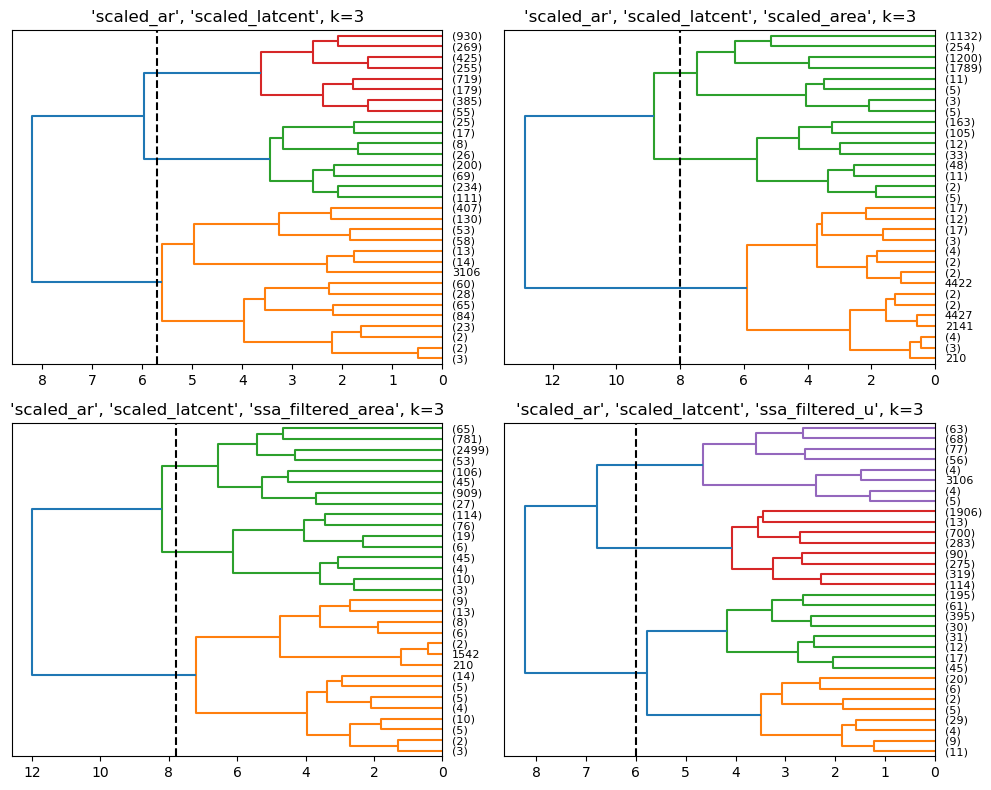

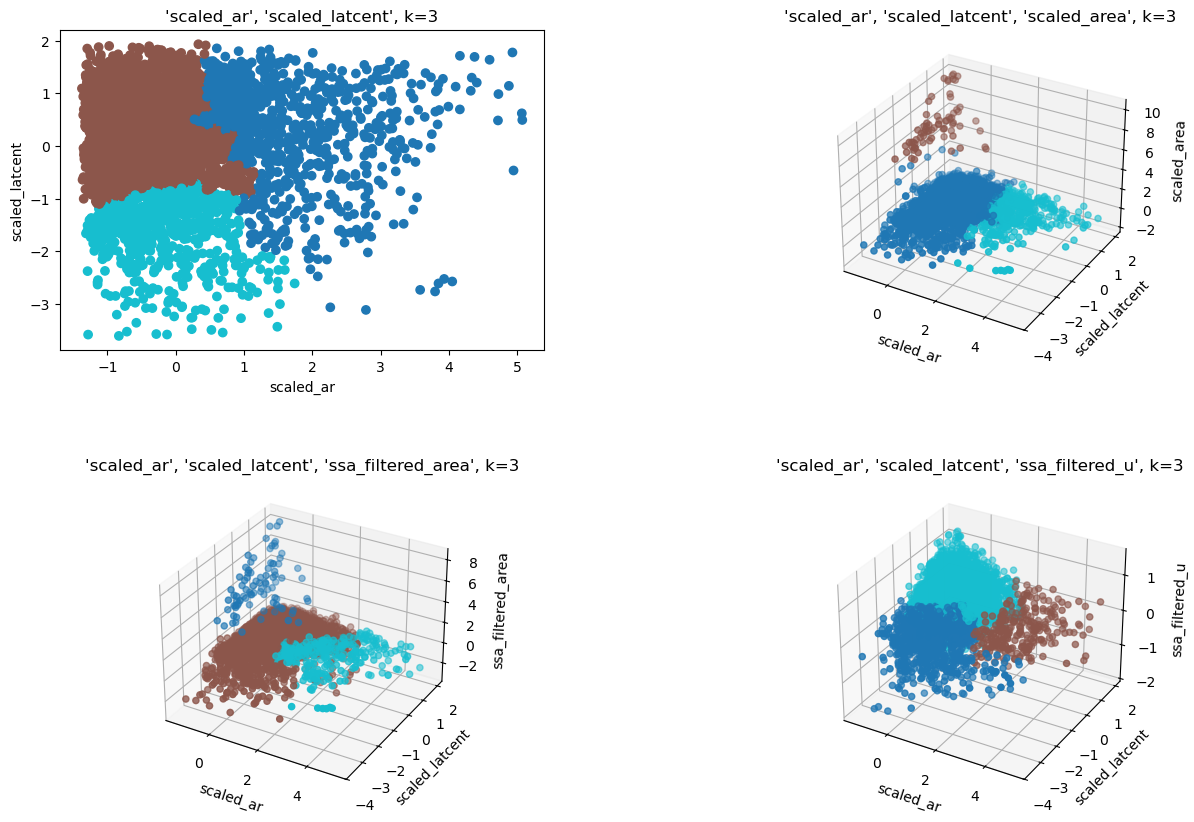

In [23]:
from sklearn import clone
from sklearn.cluster import AgglomerativeClustering
import vortexclust.visualization as viz

features_kopt = [{'features' : ['scaled_ar', 'scaled_latcent'], 'k_opt' : 3, 'line':5.7},
                 {'features' : ['scaled_ar', 'scaled_latcent', 'scaled_area'], 'k_opt' : 3, 'line':8},
                 {'features' : ['scaled_ar', 'scaled_latcent', 'ssa_filtered_area'], 'k_opt' : 3, 'line':7.8},
                 {'features' : ['scaled_ar', 'scaled_latcent', 'ssa_filtered_u'], 'k_opt' : 3, 'line':6}]


Y = []
base_model = AgglomerativeClustering(linkage='complete', compute_distances=True)

fig = plt.figure(figsize=(10,8))
for idx, feat_k in enumerate(features_kopt):
    model = clone(base_model)
    model.set_params(n_clusters = feat_k['k_opt'])
    model.fit(era5_hannachi[feat_k['features']])
    ax = fig.add_subplot(2,2,idx+1)
    ax.set_title(str(feat_k['features'])[1:-1]+", k="+str(feat_k['k_opt']))
    viz.plot_dendrogram(model, truncate_mode='level', p=4, direction='LR', savefig=f"../output/hc_{'_'.join(feat_k['features'])}_{feat_k['k_opt']}.png")
    ax.axvline(feat_k['line'], ls='--', color='black')
    y_pred = model.labels_.astype(int)
    Y.append(y_pred)
plt.tight_layout()
plt.savefig('../output/dendrogram.png')
plt.show()

fig = plt.figure(figsize=(15,10))
for idx, feat_k in enumerate(features_kopt):
    if len(feat_k['features']) == 3:
        ax = fig.add_subplot(2,2,idx+1, projection='3d')
        ax.scatter(era5_hannachi[feat_k['features']].iloc[:, 0],
                   era5_hannachi[feat_k['features']].iloc[:, 1],
                   era5_hannachi[feat_k['features']].iloc[:, 2],
                   c=Y[idx], cmap='tab10')
        ax.set_facecolor((0, 0, 0, 0))
        ax.set_xlabel(feat_k['features'][0])
        ax.set_ylabel(feat_k['features'][1])
        ax.set_zlabel(feat_k['features'][2])
    else:
        ax = fig.add_subplot(2,2, idx+1)
        ax.scatter(era5_hannachi[feat_k['features']].iloc[:, 0],
                   era5_hannachi[feat_k['features']].iloc[:, 1],
                   c=Y[idx], cmap='tab10')
        ax.set_xlabel(feat_k['features'][0])
        ax.set_ylabel(feat_k['features'][1])
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    ax.set_title(str(feat_k['features'])[1:-1]+", k="+str(feat_k['k_opt']))
plt.savefig('../output/scatter_clusters.png')
plt.show()

# Results
Below the relative and absolute distribution of physical measurements are visualized for each cluster. The goal is to identify and assign clear characteristics for each cluster. In particular, the following is expected:
- A split cluster (S) that corresponds to the threshold based assignment of split,
- A displaced cluster (D) characterized by notably low centroid latitude,
- A normal or undisturbed cluster (U) without strong anomalies.
Note that split events are usually accompanied by displacement.

## Statistical Profiles of Clusters
### Aspect ratio and Latcent
The majority of samples fall into Class **1**, which exhibits no strong geometric extremes and likely corresponds to the undisturbed state.
- Class **0** displays consistently elevated aspect ratios, with a minimum $ar_{scaled}=0.271$ (resp. $ar=1.735$), indicating highly elongated or split vortices.
- Class **2** shows significantly lower centroid latitudes, not exceeding the average at 0.

Based on these profiles, clusters are assigned as follows:

**0** &rarr; S (Split)<br>
**1** &rarr; U (Undisturbed/normal state)<br>
**2** &rarr; D (Displaced)

y_ar_latcent_scArea
['scaled_ar', 'scaled_latcent', 'scaled_area']
                     PC0       PC1       PC2
scaled_ar       0.160602  0.983865 -0.078841
scaled_latcent -0.693517  0.169322  0.700260
scaled_area     0.702311 -0.057785  0.709521
Expl_var        1.159981  0.996954  0.843684
Expl_var_ratio  0.386580  0.332249  0.281170


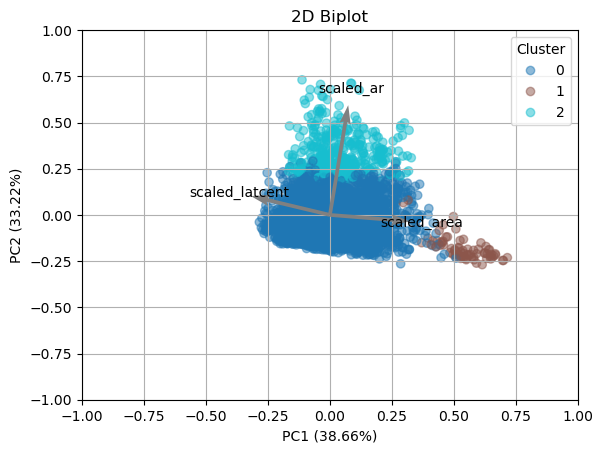

y_ar_latcent_filteredArea
['scaled_ar', 'scaled_latcent', 'ssa_filtered_area']
                        PC0       PC1       PC2
scaled_ar         -0.509916 -0.672948  0.535843
scaled_latcent    -0.449783  0.739551  0.500759
ssa_filtered_area  0.733268 -0.014332  0.679789
Expl_var           1.059222  1.009861  0.931536
Expl_var_ratio     0.353001  0.336551  0.310448


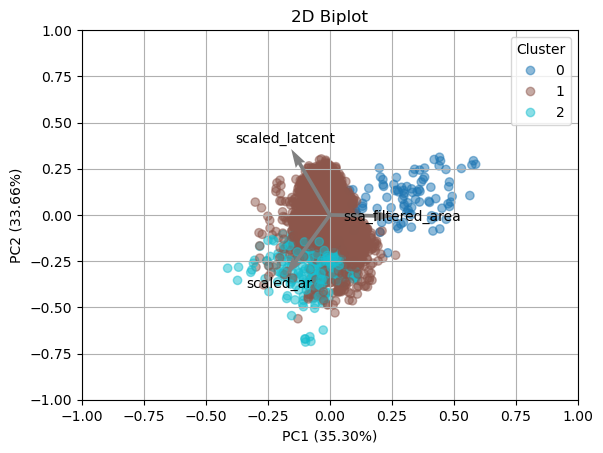

y_ar_latcent_u
['scaled_ar', 'scaled_latcent', 'ssa_filtered_u']
                     PC0       PC1       PC2
scaled_ar      -0.373207  0.855304  0.359405
scaled_latcent  0.604142  0.518051 -0.605505
ssa_filtered_u  0.704081  0.008847  0.710065
Expl_var        1.512160  0.991612  0.496847
Expl_var_ratio  0.503949  0.330469  0.165581


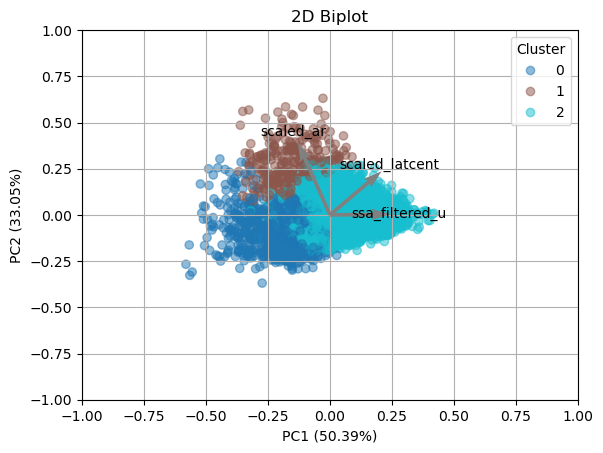

                       PC0       PC1       PC2       PC3
counter_d        -0.003879  0.009372  0.035817  0.506359
time_d           -0.003879  0.009372  0.035817  0.506359
year             -0.002672  0.009630  0.036771  0.507729
month            -0.052776 -0.010547 -0.041605 -0.056098
day               0.001090  0.004960  0.006556 -0.001305
edge             -0.132956  0.306700  0.015562  0.098513
form              0.280472  0.142946 -0.028652 -0.010724
area             -0.137702  0.284178 -0.007216 -0.063729
obj_area         -0.076638  0.157765 -0.016324 -0.104306
latcent          -0.097416  0.130847 -0.089136 -0.196376
loncent          -0.072759  0.131719 -0.002510 -0.012324
theta             0.007543  0.024132 -0.005248  0.040849
ar                0.238320 -0.085171  0.013621  0.051865
kurtosis          0.033055 -0.097327  0.049048  0.164554
area1             0.275023  0.144200 -0.025976 -0.008741
obj_area1         0.246253  0.120097 -0.023380 -0.030564
latcent1          0.278128  0.1

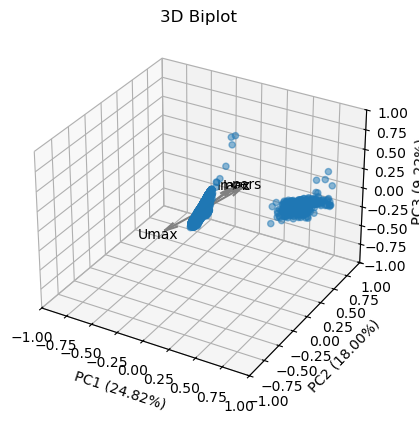

In [26]:
y_names = ['y_ar_latcent', 'y_ar_latcent_scArea', 'y_ar_latcent_filteredArea', 'y_ar_latcent_u']
era5_hannachi[y_names] = pd.DataFrame(Y).T

# compute most important features for each feature set
for feat_k, y in zip(features_kopt[1:], y_names[1:]):
    features = feat_k['features']
    print(y)
    print(features)
    x_new, pc, pca = vortexclust.compute_pca(era5_hannachi[features], n_comp=len(features))
    print(pc)
    viz.plot_pca(pca, x_new, features, labels = era5_hannachi[y])

x_new, pc, pca = vortexclust.compute_pca(era5_all.select_dtypes(include=np.number))
print(pc)
viz.plot_pca(pca, x_new, era5_all.select_dtypes(include=np.number).columns, plot_type='3D')

Averages per class and features:
              scaled_ar  scaled_latcent
y_ar_latcent                           
D             -0.139642       -1.635846
S              1.560738        0.333360
U             -0.436129        0.299781
y_ar_latcent
U    3217
S     943
D     690
Name: count, dtype: int64


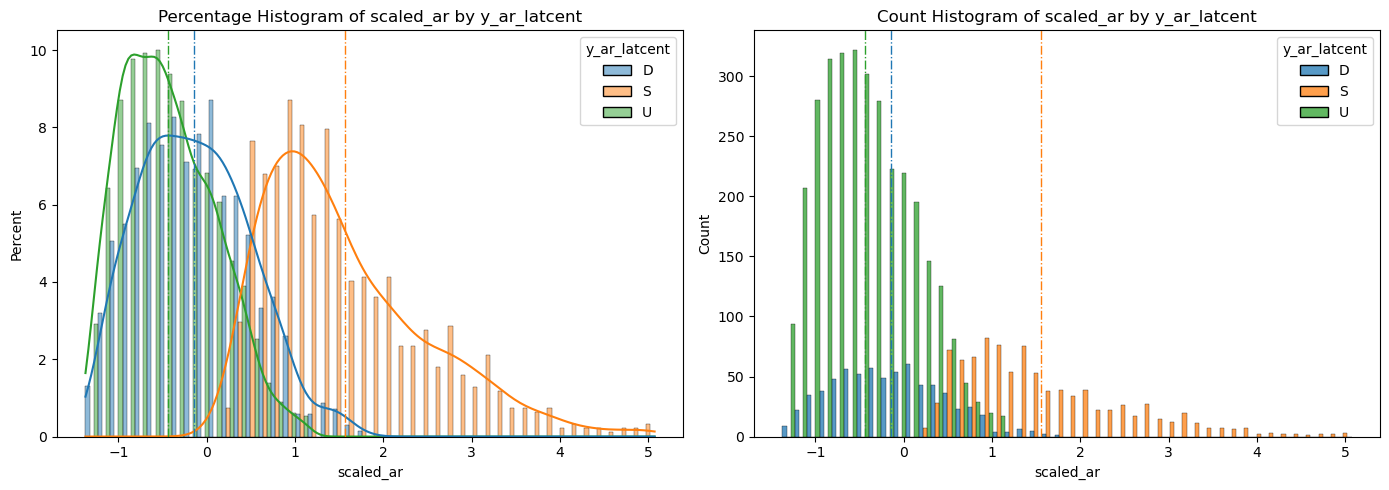

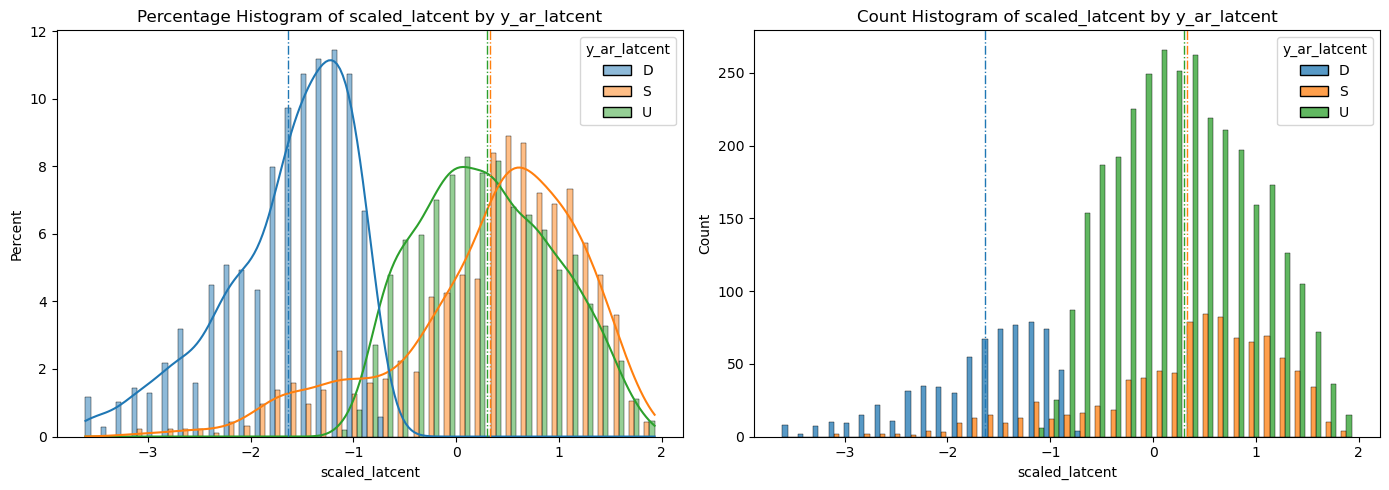

In [25]:
from vortexclust.workflows.demo import plot_hist_per_class

# Cluster mapping assumed: 0 → S (split), 1 → U (undisturbed), 2 → D (displaced)
era5_hannachi['y_ar_latcent'] = era5_hannachi['y_ar_latcent'].replace({0: 'S', 1:'U', 2:'D'})
print("Averages per class and features:")
print(era5_hannachi[['y_ar_latcent', 'scaled_ar', 'scaled_latcent']].groupby(['y_ar_latcent']).mean())
print(era5_hannachi['y_ar_latcent'].value_counts())


plot_hist_per_class(era5_hannachi, # data
                    features_kopt[0], # information about used feature and k_opt
                    'y_ar_latcent') # column name with y values

### Aspect ratio, latcent and wind speed
Including the wind speed as a proxy for the area in H11 enhances the separation between the above classes.
- Class **2** becomes the largest group, characterised by near average values for latcent and ar, but notably higher wind speeds.
- Class **1** exhibits a significantly larger aspect ratio, consistent with elongated or split vortex structures.
- Class **0** displays a significantly lower centroid latitudes, indicating displaced vortices. latcent.

Interestingly, class **1** and **0** show similar distributions for the wind speed, but generally weaker winds than **2**. This agrees with the understanding that split and disturbed events are often associated with weakened westerlies or even reversed winds. Accordingly, classes are interpreted as:

**0** &rarr; D (Displaced)<br>
**1** &rarr; S (Split)<br>
**2** &rarr; U (Undisturbed/normal state)

Averages per class and features:
                scaled_ar  scaled_latcent  ssa_filtered_u
y_ar_latcent_u                                           
D                0.182125       -1.500504       -0.381814
S                2.601232        0.257020       -0.292167
U               -0.245826        0.374867        0.117274
y_ar_latcent_u
U    3700
D     872
S     278
Name: count, dtype: int64


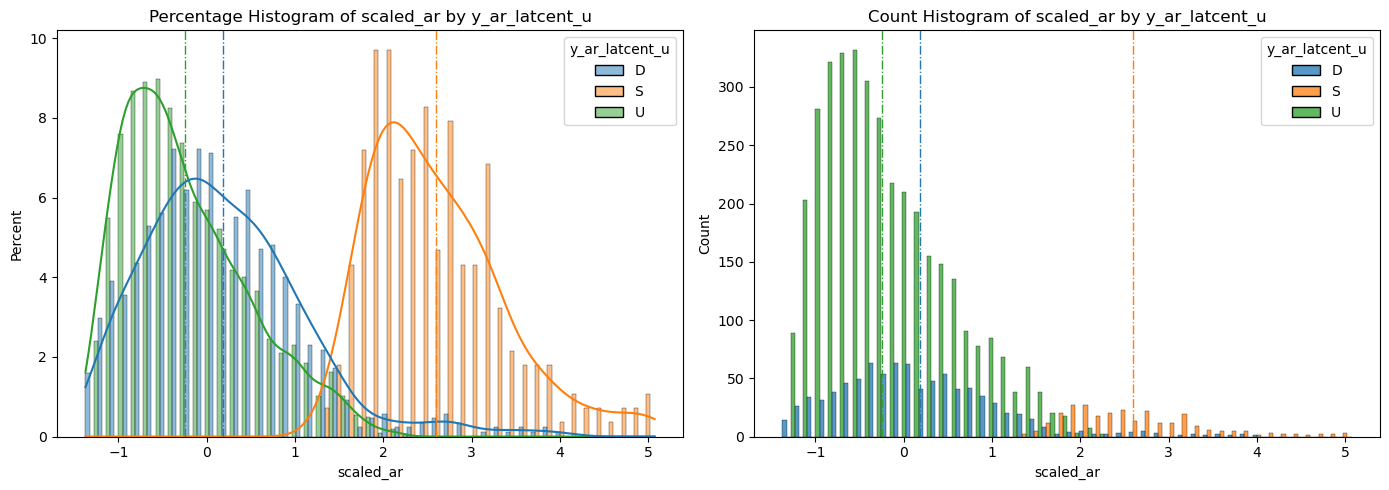

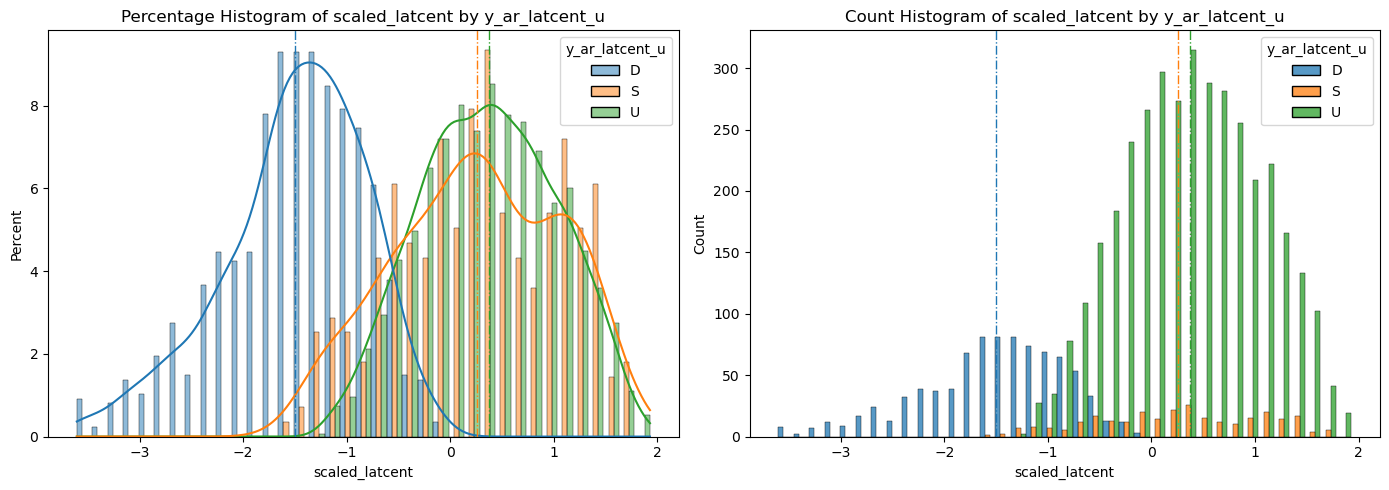

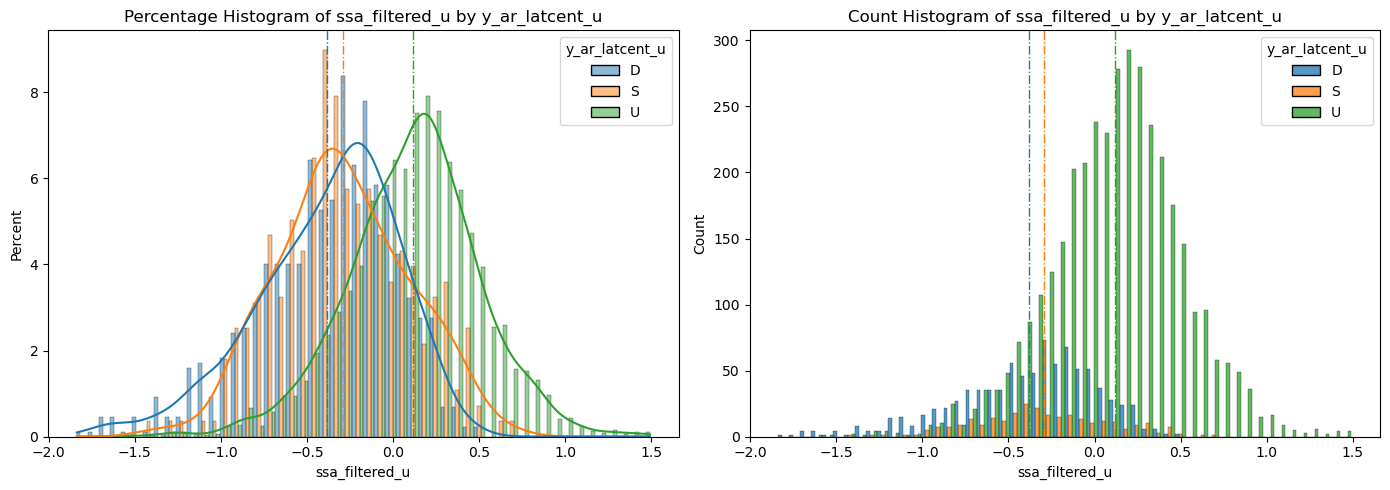

In [22]:
era5_hannachi['y_ar_latcent_u'] = era5_hannachi['y_ar_latcent_u'].replace({0:'D', 1:'S', 2:'U'})
print("Averages per class and features:")
print(era5_hannachi[['y_ar_latcent_u', 'scaled_ar', 'scaled_latcent', 'ssa_filtered_u']].groupby(['y_ar_latcent_u']).mean())
print(era5_hannachi['y_ar_latcent_u'].value_counts())

plot_hist_per_class(era5_hannachi, # data
                    features_kopt[3], # information about used feature and k_opt
                    'y_ar_latcent_u') # column name with y values


### Aspect ratio, latcent and vortex area

Incorporating the vortex area computed from 10 hPa geopotential height introduces some ambiguity in the cluster interpretation. As before, a class with elevated aspect ratio can still be identified, in both filtered and unfiltered cases. This corresponds to class **2**.

However, the centroid latitude distribution is largely indistinguishable across all classes in both scenarios, limiting its usefulness for classification in this context.

The key distinction appears in the vortex area. In each case, one cluster contains a small number of samples with very large area values, which skews the distribution significantly. To reflect this, we introduce a new label: L (Large), for these high-area events that don’t clearly correspond to displaced or split morphology.

The resulting label assignments are:

For the unfiltered area:<br>
**0** &rarr; U (Undisturbed/normal state)<br>
**1** &rarr; L (Large)<br>
**2** &rarr; S (Split)

For the filtered area:<br>
**0** &rarr; L (Large)<br>
**1** &rarr; U (Undisturbed/normal state)<br>
**2** &rarr; S (Split)

Averages per class and features:
                     scaled_ar  scaled_latcent  scaled_area
y_ar_latcent_scArea                                        
L                    -0.943072        0.342066     6.904661
S                     2.431698        0.276978     0.117099
U                    -0.200344        0.004641    -0.127405
y_ar_latcent_scArea
U    4399
S     379
L      72
Name: count, dtype: int64


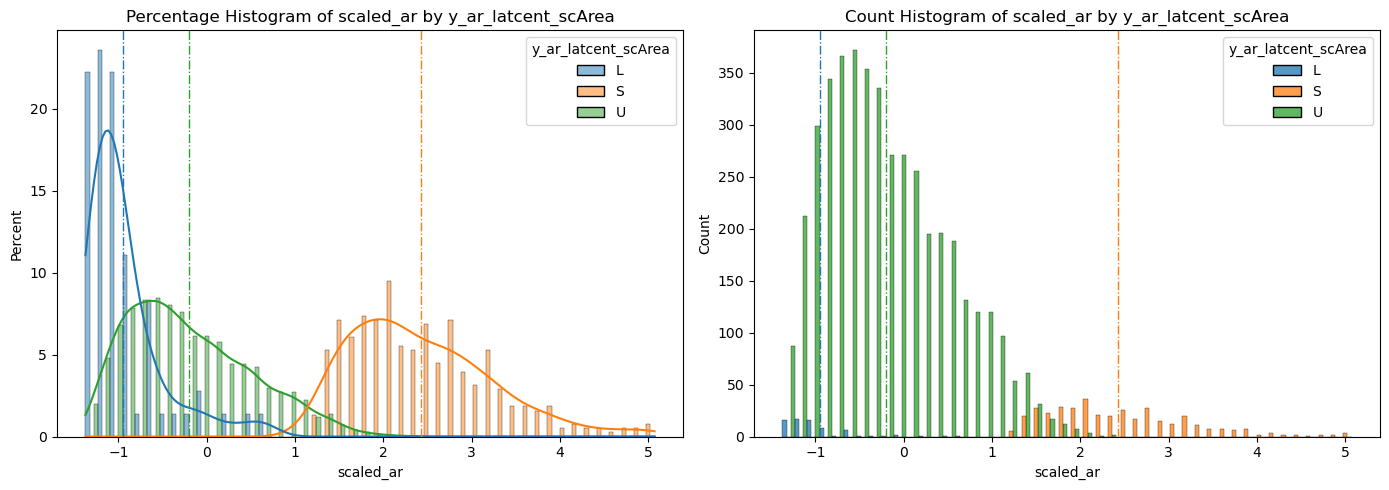

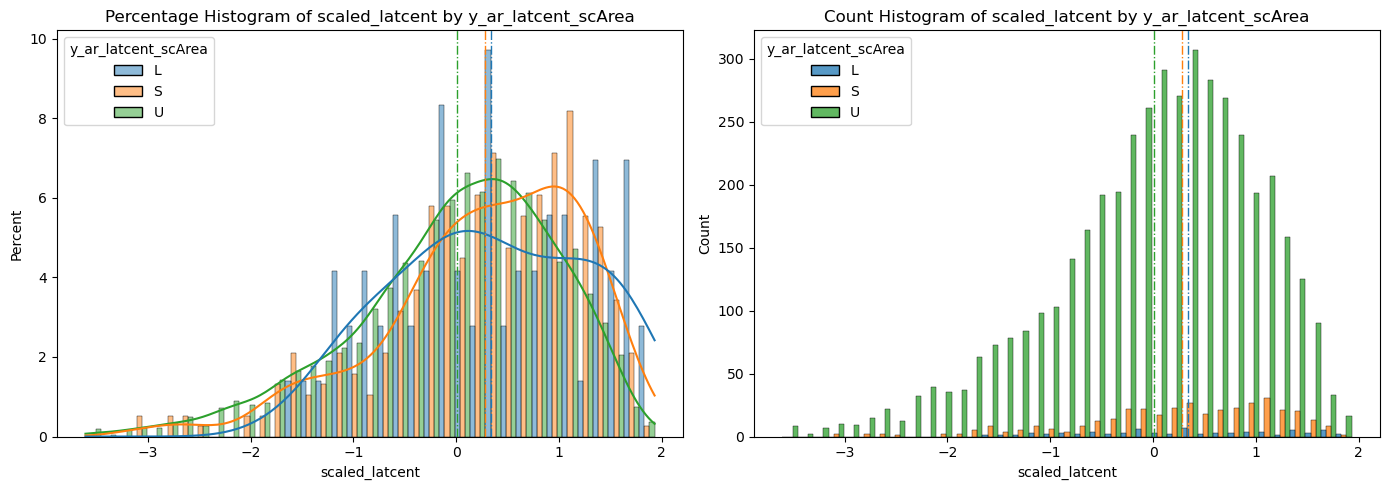

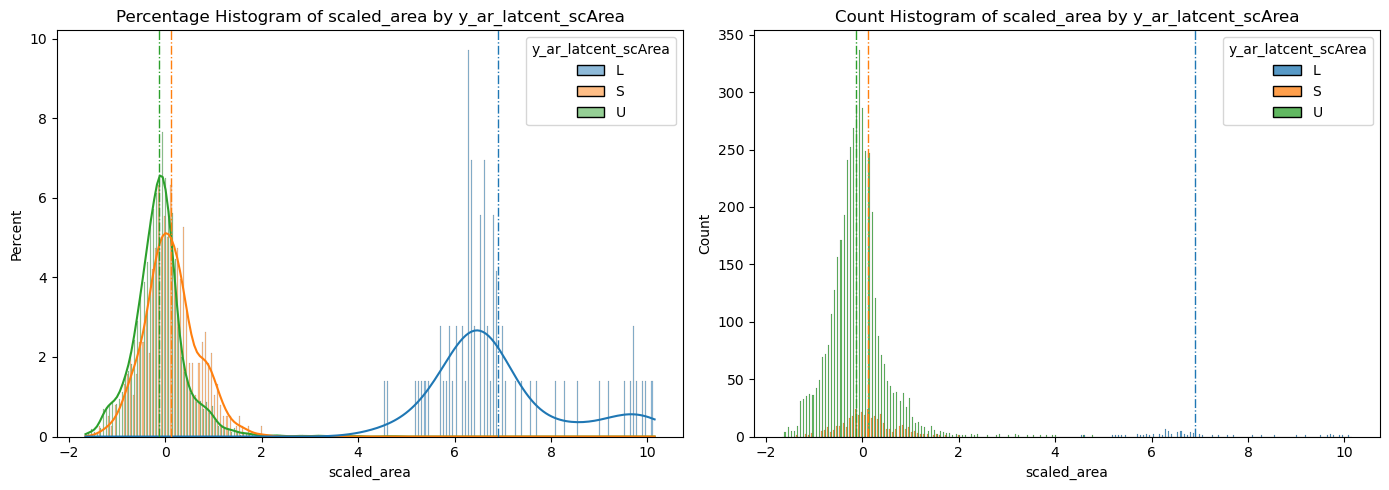

Averages per class and features:
                           scaled_ar  scaled_latcent  ssa_filtered_area
y_ar_latcent_filteredArea                                              
L                          -0.844085        0.270181           4.131017
S                           2.488939       -0.261740           0.276208
U                          -0.143313        0.044313          -0.099780
y_ar_latcent_filteredArea
U    4485
S     277
L      88
Name: count, dtype: int64


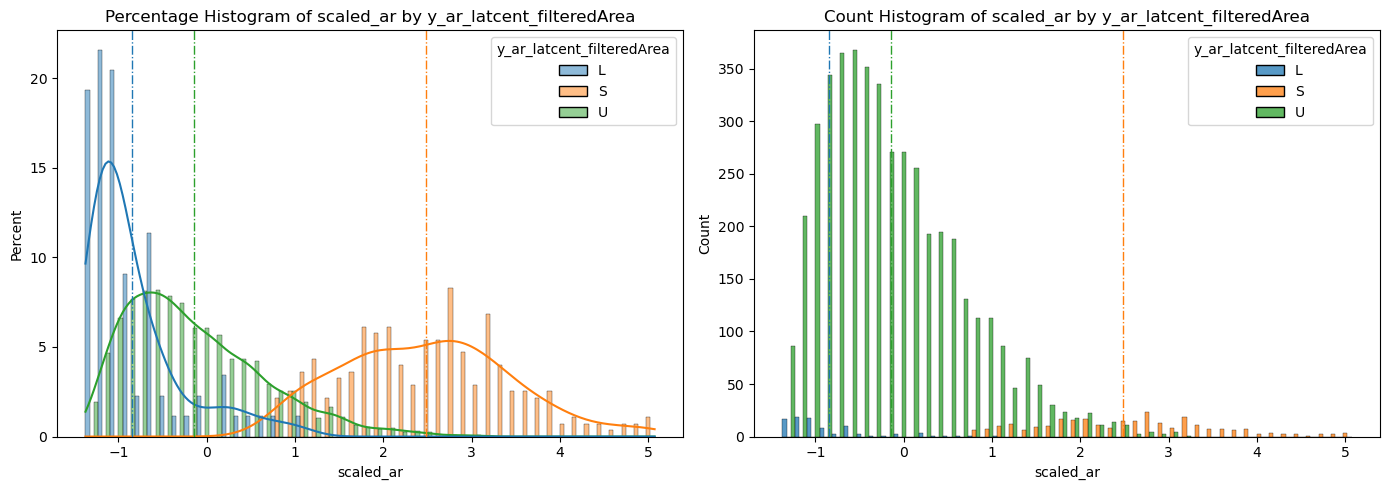

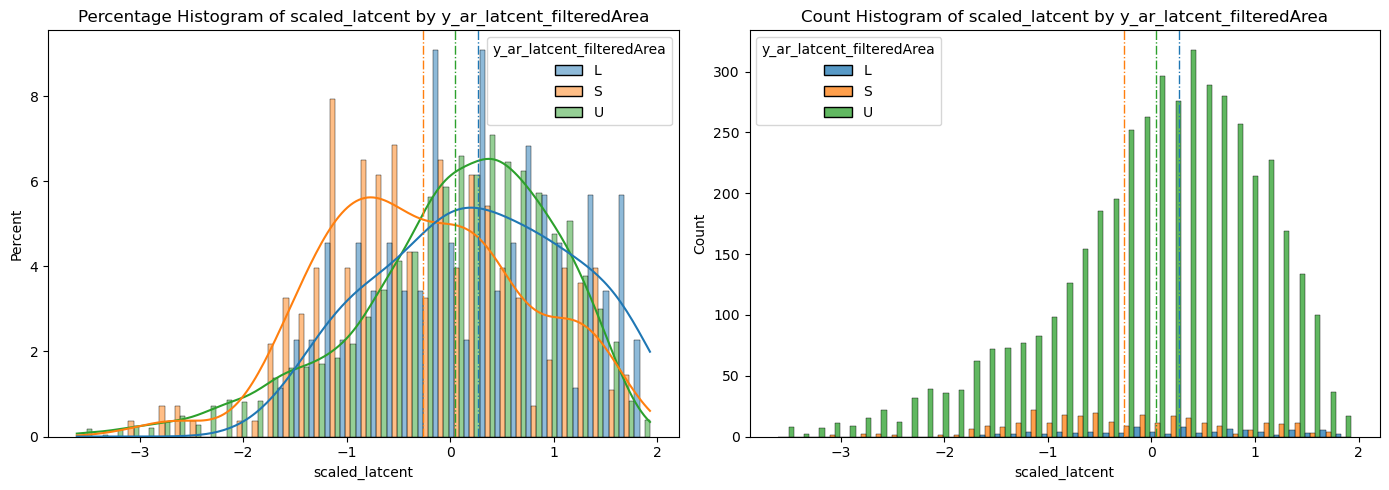

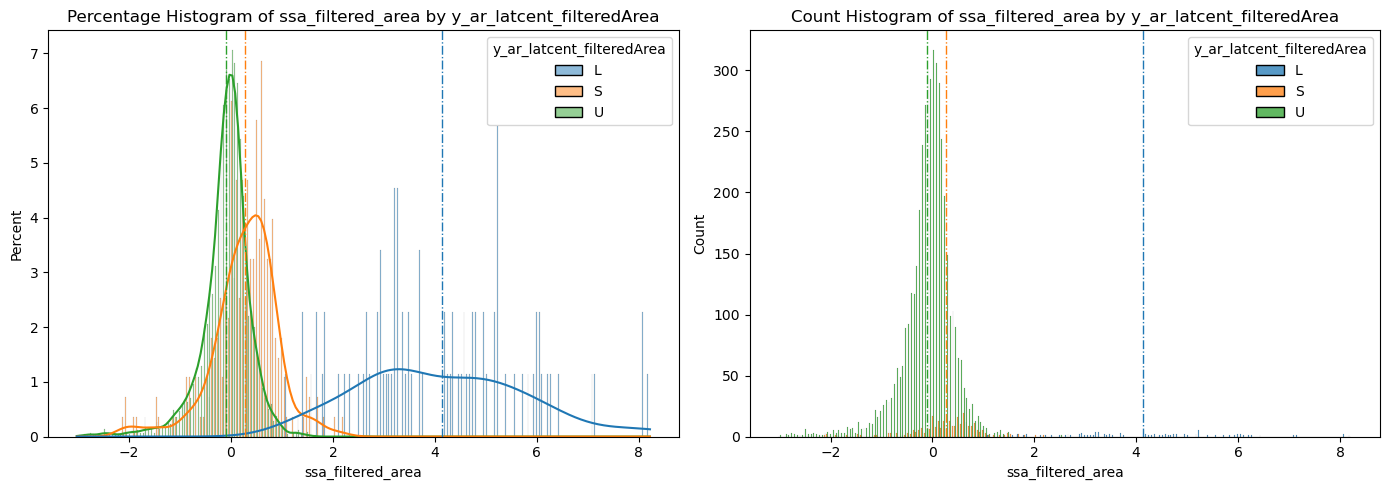

In [23]:
era5_hannachi['y_ar_latcent_scArea'] = era5_hannachi['y_ar_latcent_scArea'].replace({0: 'U', 1:'L', 2:'S'})
era5_hannachi['y_ar_latcent_filteredArea'] = era5_hannachi['y_ar_latcent_filteredArea'].replace({0: 'L', 1:'U', 2:'S'})

print("Averages per class and features:")
print(era5_hannachi[['y_ar_latcent_scArea', 'scaled_ar', 'scaled_latcent', 'scaled_area']].groupby(['y_ar_latcent_scArea']).mean())
print(era5_hannachi['y_ar_latcent_scArea'].value_counts())

# noinspection SpellCheckingInspection
plot_hist_per_class(era5_hannachi, # data
                    features_kopt[1], # information about used feature and k_opt
                    'y_ar_latcent_scArea') # column name with y values

print("Averages per class and features:")
print(era5_hannachi[['y_ar_latcent_filteredArea', 'scaled_ar', 'scaled_latcent', 'ssa_filtered_area']].groupby(['y_ar_latcent_filteredArea']).mean())
print(era5_hannachi['y_ar_latcent_filteredArea'].value_counts())
plot_hist_per_class(era5_hannachi, # data
                    features_kopt[2], # information about used feature and k_opt
                    'y_ar_latcent_filteredArea') # column name with y values

## Physical interpretation and Literature Comparison

The following table illustrates the distribution of classes in H11:

<table>
  <tr>
    <th></th>
    <th colspan="4">AR, Latcent and filtered Area</th>
  </tr>
  <tr>
    <th>AR, Latcent</th>
    <th>D (0) </th>
    <th>U (2) </th>
    <th>S (1) </th>
    <th>Total</th>
  </tr>
  <tr>
    <th>D (2) </th>
    <td>7</td>
    <td>3</td>
    <td>0</td>
    <td>10</td>
  </tr>
  <tr>
    <th>U (1)</th>
    <td>4</td>
    <td>80</td>
    <td>2</td>
    <td>86</td>
  </tr>
  <tr>
    <th>S (0)</th>
    <td>1</td>
    <td>0</td>
    <td>3</td>
    <td>4</td>
  </tr>
  <tr>
    <th>Total</th>
    <td>12</td>
    <td>83</td>
    <td>5</td>
    <td>100</td>
  </tr>
</table>

When using wind speed as a proxy for vortex area, the clustering aligns closely with the class proportions reported by H11. Approximately 5% of events are consistently identified as split in both models.

In contrast, the model using only AR and Latcent tends to overestimate split events, while slightly underrepresenting the undisturbed class. The inclusion of filtered wind speed corrects this overestimation, resulting in a distribution that more faithfully reproduces the structure found in H11.

Notably, both approaches overestimate displaced events (D) by 4–6% compared to H11. This suggests that the centroid latitude alone may not be sufficient to isolate displacement events robustly, especially in cases where they occur with splits or large area structures.

In [24]:
pd.pivot_table(data=era5_hannachi[['y_ar_latcent', 'string','y_ar_latcent_u']], index='y_ar_latcent', columns='y_ar_latcent_u', aggfunc = 'count', margins=True)/era5_hannachi.shape[0]*100

string                                 
y_ar_latcent_u          D         S          U         All
y_ar_latcent                                              
D               13.154639       NaN   1.072165   14.226804
S                2.226804  5.731959  11.484536   19.443299
U                2.597938       NaN  63.731959   66.329897
All             17.979381  5.731959  76.288660  100.000000

A reference classification of split versus displaced events was derived directly from the aspect ratio within the elliptical diagnostics. In this scheme, every event is categorized as either split or displaced, based solely on geometric thresholds.

All models are evaluated against this geometric classification to assess how well they capture the split regime. To quantify this, standard classification metrics are used: accuracy, precision, recall, and F1 score. These are defined based on:

To compare the classification by the hierarchical models to the computed split and displaced classification, the measures of accuracy (acc), precision, recall and f1 score are introduced. They base on the notion of
- true positive (TP), i.e. an even is clustered and computed as split,
- true negative (TN), i.e. an event is not clustered as split and not computed as such,
- false positive (FP), i.e. an event is clustered as split, but not computed as split,
- false negative (FN), i.e. an event is marked as not split, but was computed as split.

The four metrics are calculated as follows:
$$
acc = \frac{TN+TP}{TP+TN+FP+FN}
$$
$$
precision = \frac{TP}{TP+FP}
$$
$$
recall = \frac{TP}{TP+FN}
$$
$$
f1 = \frac{2*precision*recall}{precision+recall}
$$

All scores range from 0 (worst) to 1 (best). The model using AR, Latcent, and filtered wind speed achieves the best overall balance, with:
- accuracy = 0.98
- precision = 0.76
- recall = 0.84

Although the minimal model (AR and Latcent only) achieves perfect recall (1.0), it significantly overestimates split events, resulting in a high number of false positives and a much lower precision. This highlights the trade-off between sensitivity and specificity when relying on geometric features alone. Adding filtered wind speed greatly reduces overclassification while still retaining good sensitivity to actual split events.

In [25]:
from vortexclust.workflows.demo import compare_cluster

compare_cluster(era5_hannachi.merge(era5_all[['string', 'form']], on='string', how='inner'), compare_col='form', pred_value='S', gt_value=1)

----------------------------------------------
Comparison of Percentages:  y_ar_latcent (predicted: S) vs form (ground truth: 1)
y_ar_latcent      D      S      U     All
form                                     
0             14.23  14.27  66.33   94.82
1              0.00   5.18   0.00    5.18
All           14.23  19.44  66.33  100.00
Accuracy: 0.86
Precision: 0.27
Recall: 1.0
F1 Score: 0.42
----------------------------------------------
Comparison of Percentages:  y_ar_latcent_scArea (predicted: S) vs form (ground truth: 1)
y_ar_latcent_scArea     L     S      U     All
form                                          
0                    1.48  2.76  90.58   94.82
1                    0.00  5.05   0.12    5.18
All                  1.48  7.81  90.70  100.00
Accuracy: 0.97
Precision: 0.65
Recall: 0.98
F1 Score: 0.78
----------------------------------------------
Comparison of Percentages:  y_ar_latcent_filteredArea (predicted: S) vs form (ground truth: 1)
y_ar_latcent_filteredArea     L

Seviour et al. (2013) presented a threshold based method to distinguish between split and displaced events. A displaced event is defined as:

> Displaced events are identified if the centroid latitude remains equatorward 66ıN for 7 days or more.7

And a split event as:
> Split events are identified if the aspect ratio remains above 2.4 for 7 days or more.

To avoid overlapping detections, no two events may occur within 30 days. If they do, the first occurrence determines the classification.

Key results:

| Feature Set                          | Accuracy | Precision | Recall   | F1 Score |
|--------------------------------------|----------|-----------|----------|----------|
| **AR, Latcent**                      | 0.83     | 0.13      | 1.00     | 0.24     |
| **AR, Latcent, Area**                | 0.95     | 0.32      | 0.95     | 0.48     |
| **AR, Latcent, Filtered Area**       | 0.96     | 0.36      | 0.79     | 0.49     |
| **AR, Latcent, Filtered Wind Speed** | **0.96** | **0.40**  | **0.89** | **0.55** |

In comparison with this reference scheme, the model including filtered wind speed shows the best alignment, confirming its ability to reliably detect split events consistent with duration based physical criteria. It not only captures the statistical split regime robustly (as shown by its highest F1 score), but also reflects the duration based thresholds used in operational diagnostics. This supports its use as a reliable alternative to static, rule based event detection.
The minimal model using ar and latcent achieves perfect recall, but suffers from overclassification (precision = 0.13), mirroring its behaviour against the geometric `form` flag. The models improve significantly when including area.

This confirms that temporal filtering and dynamic proxies like wind speed provide meaningful improvements over purely geometric moment clustering, especially for aligning with physically interpretable definitions of vortex splitting.

In [27]:
labels = vortexclust.split_displaced_seviour(era5_hannachi[['ar', 'latcent', 'string']])
era5_hannachi['seviour'] = labels

compare_cluster(era5_hannachi, compare_col = 'seviour', pred_value = 'D', gt_value='displaced', y_names=['y_ar_latcent', 'y_ar_latcent_u'])

----------------------------------------------
Comparison of Percentages:  y_ar_latcent (predicted: D) vs seviour (ground truth: displaced)
y_ar_latcent      D      S      U     All
seviour                                  
displaced      1.32   0.23   0.00    1.55
split          0.00   2.60   0.00    2.60
undisturbed   12.91  16.62  66.33   95.86
All           14.23  19.44  66.33  100.00
Accuracy: 0.87
Precision: 0.09
Recall: 0.85
F1 Score: 0.17
----------------------------------------------
Comparison of Percentages:  y_ar_latcent_u (predicted: D) vs seviour (ground truth: displaced)
y_ar_latcent_u      D     S      U     All
seviour                                   
displaced        1.55  0.00   0.00    1.55
split            0.21  2.31   0.08    2.60
undisturbed     16.23  3.42  76.21   95.86
All             17.98  5.73  76.29  100.00
Accuracy: 0.84
Precision: 0.09
Recall: 1.0
F1 Score: 0.16


### Comparison to Major Warmings
Although not directly diagnostic of vortex morphology, major stratospheric warmings (MWs) are crucial for understanding sudden disruptions in vortex structure. The table below shows the distribution of cluster assignments across MW and non-MW periods, expressed as percentages of the full dataset.

Key Observations:
- Major Warmings (MW = 1) occur in ~3.9% of the dataset
- In all models, MWs are disproportionately associated with split and displaced clusters.
    - For the AR + Latcent model, over 80% of MW events fall into the S or D clusters.
    - In contrast, the undisturbed (U) cluster dominates the non-MW periods.
- The filtered wind speed model maintains this pattern while reducing noise — MWs account for:
    - 2.10% of class D
    - 0.85% of class S
    - 0.95% of class U

These results are consistent with the physical understanding that MWs often coincide with major vortex disruptions, including splits and displacements. While not all splits are major warmings, and not all warmings result in splits, the alignment across models indicates that the clustering meaningfully captures dynamical states with increased MW likelihood.

In [1]:
for y in y_names:
    print(np.round(pd.pivot_table(era5_hannachi.merge(era5_all[['string', 'MW']], on='string', how='inner')[['MW', y, 'string']], index='MW', columns=y, aggfunc='count', margins=True)/era5_hannachi.shape[0]*100,2))

NameError: name 'y_names' is not defined

### Overview of descriptive statistics for each class

Below the statistics for all features are displayed. The minimum (resp. maximum) in each column is marked violett (resp. yellow).

In [29]:
# All numeric columns excluding IDs and classifications
exclude_cols = ['string', 'counter_d', 'time_d'] + [col for col in era5_hannachi.columns if col.startswith('y_')]
exclude_cols.extend(['area1', 'obj_area1', 'latcent1', 'loncent1', 'theta1', 'ar1', 'area2', 'obj_area2', 'latcent2', 'loncent2', 'theta2', 'ar2'])
numeric_cols = era5_all.select_dtypes(include='number').columns
cols_to_summarize = [col for col in numeric_cols if (col not in exclude_cols and col not in era5_hannachi.columns)]

merged = era5_hannachi.merge(era5_all[cols_to_summarize+['string']], on='string', how='inner')
summary_dict = {}

for model in y_names:
    grouped_all = merged.groupby(model)[cols_to_summarize].agg(['min', 'mean', 'max'])
    grouped_hannachi = era5_hannachi.groupby(model)[era5_hannachi.select_dtypes(include='number').columns].agg(['min', 'mean', 'max'])
    summary_dict[model] = [grouped_all, grouped_hannachi]

pd.set_option('display.precision', 2)
for model, df in summary_dict.items():
    print(f"\n Summary statistics from all data for {model}:")
    df_all = df[0]
    hannachi = df[1]
    display(df_all.style.format("{:.2f}").background_gradient(axis=0, cmap ="viridis"))
    print(f"\n Summary statistics from data used by H11 for {model}:")
    display(hannachi.style.format("{:.2f}").background_gradient(axis=0, cmap ="viridis"))


 Summary statistics from all data for y_ar_latcent:



 Summary statistics from data used by H11 for y_ar_latcent:



 Summary statistics from all data for y_ar_latcent_scArea:



 Summary statistics from data used by H11 for y_ar_latcent_scArea:



 Summary statistics from all data for y_ar_latcent_filteredArea:



 Summary statistics from data used by H11 for y_ar_latcent_filteredArea:



 Summary statistics from all data for y_ar_latcent_u:



 Summary statistics from data used by H11 for y_ar_latcent_u:


### Schematic plot of vortex of representative sample for each found cluster
To visually characterize the dynamical structure of each cluster, a representative vortex configuration is selected. For each class in each model:

1. The cluster mean is computed for a set of geometric and diagnostic features (ar, latcent, area, etc.)
2. The sample closest to this mean in Euclidean space is selected as the representative day.
3. To illustrate the vortex evolution, the day **before** and **after** the representative are included in the plot.

Each 3-day window is visualized using the plot_polar_stereo function in overlay mode. If a split event or major warming is present in the window, this is noted in the output. This allows for qualitative assessment of how each class relates to key vortex phenomena and helps confirm the physical consistency of the clustering results.

In [37]:
from sklearn.metrics.pairwise import euclidean_distances
from datetime import timedelta

foi = ['ar', 'latcent', 'kurtosis',
       'scaled_area', 'scaled_ar', 'scaled_latcent', 'scaled_kurtosis',
       'ssa_filtered_area', 'ssa_filtered_u']
for y in y_names:
    print('y: ', y)
    for c in era5_hannachi[y].unique():
        print('class: ', c)
        # compute all means
        mean_vec = era5_hannachi[era5_hannachi[y] == c][foi].mean()
        # compute distance of each sample to mean
        dist_mean = euclidean_distances(era5_hannachi[foi], [mean_vec])
        # determine index of sample closest to mean
        mean_idx = dist_mean.argmin()
        # obtain representative sample
        rep_mean = era5_hannachi.iloc[mean_idx]
        # print("Representative mean has class: ", rep_mean[y])

        dates = [rep_mean.string + timedelta(days=i) for i in range(-1, 2)]
        samples = era5_all[era5_all.string.isin(dates)]
        if samples.form.sum() > 0:
            print('split event in time range')
        if samples.MW.sum() > 0:
            print('MW event in time range')

        # print(isinstance(samples, pd.DataFrame))
        viz.plot_polar_stereo(samples, time_col='string', mode='overlay', figsize=(15, 15))

y:  y_ar_latcent
class:  U


TypeError: Expected a pandas.DataFrame or pandas.Series

# Appendix
For reasons of interest in the data the following was kept.

## Computation of the partial autocorrelation function
The partial autocorrelation function does not exhibit any remarkable perks except for the wind speed reduced to DJFM. The visible peaks correspond closely to the suggested time window of 120 days and indicate a 120d periodic signal in the data.

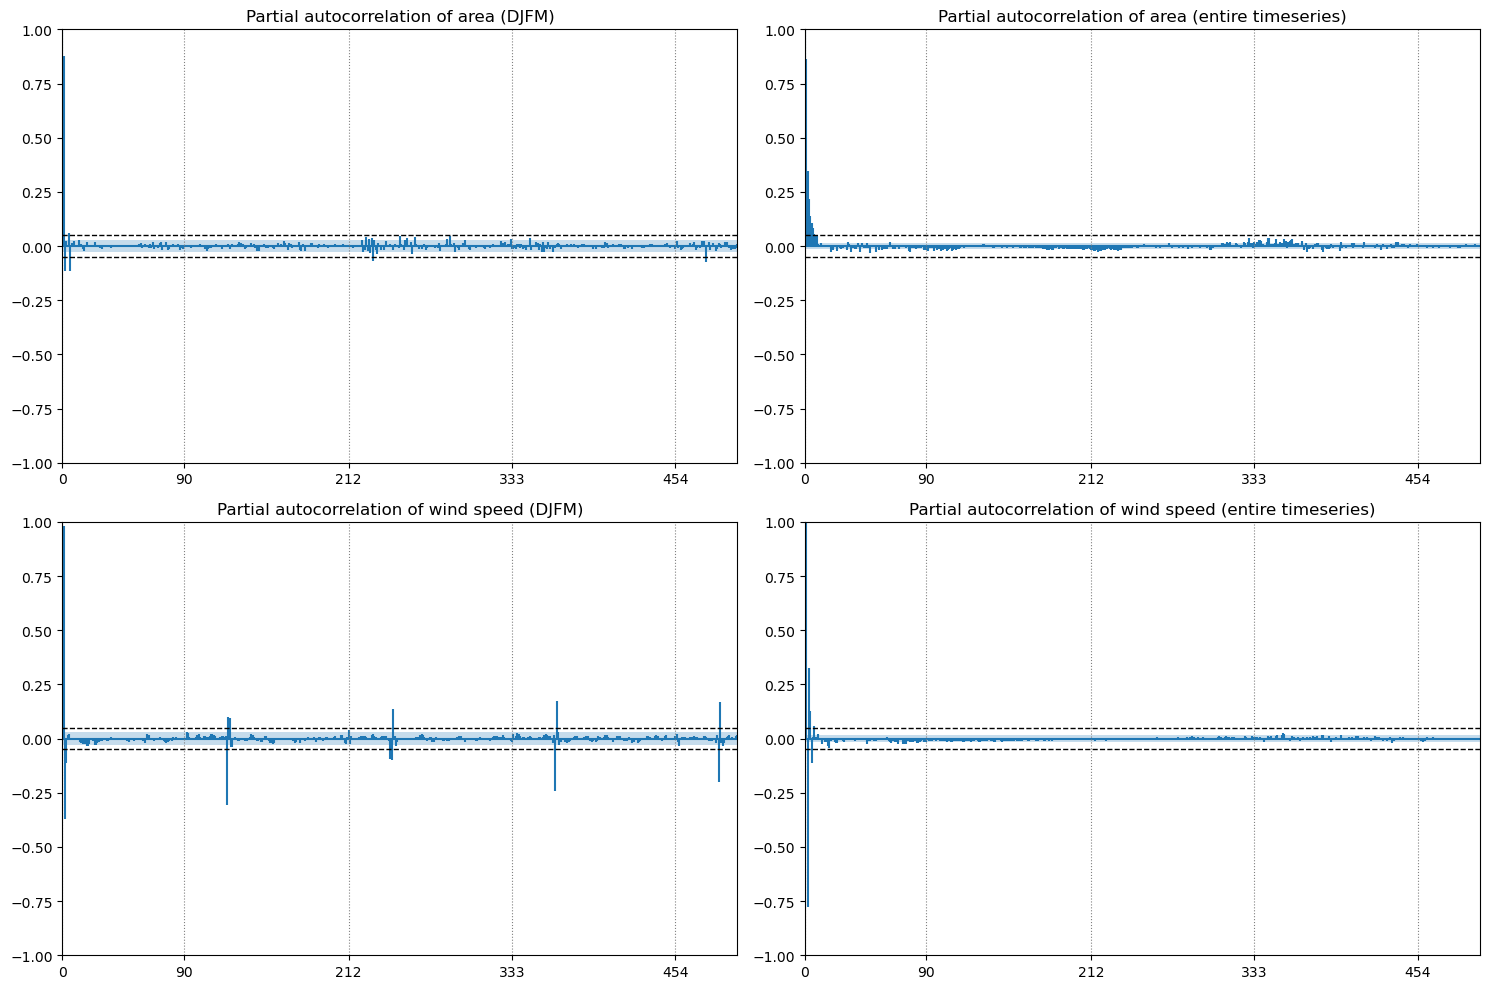

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(2,2, figsize=(15, 10))
ax = ax.flatten()
plot_pacf(era5_hannachi['scaled_area'], lags=500, ax=ax[0], label='PACF scaled area (DJFM)', marker=None)
plot_pacf(era5_all['scaled_area'], lags=500, ax=ax[1], label='PACF scaled area (entire timeseries)', marker=None)
plot_pacf(era5_hannachi['scaled_u'], lags=500, ax=ax[2], label='PACF wind speed (DJFM)', marker=None)
plot_pacf(era5_all['scaled_u'], lags=500, ax=ax[3], label='PACF wind speed (entire timeseries)', marker=None)

ax[0].set_title('Partial autocorrelation of area (DJFM)')
ax[1].set_title('Partial autocorrelation of area (entire timeseries)')
ax[2].set_title('Partial autocorrelation of wind speed (DJFM)')
ax[3].set_title('Partial autocorrelation of wind speed (entire timeseries)')

for i in range(4):
    ax[i].axhline(y=0.05, linestyle='--', color='black', linewidth=1)
    ax[i].axhline(y=-0.05, linestyle='--', color='black', linewidth=1)
    ax[i].set_xlim(0, 500)
    ax[i].set_xticks(positions[:5])
    for x in positions:
        ax[i].axvline(x=x, color='grey', linestyle=':', linewidth=0.8)
plt.tight_layout()
plt.show()

## Year over Year averages

Below the yearly seasonality is computed with the year over year average as well as the reconstruction of the yearly seasonality with SSA.

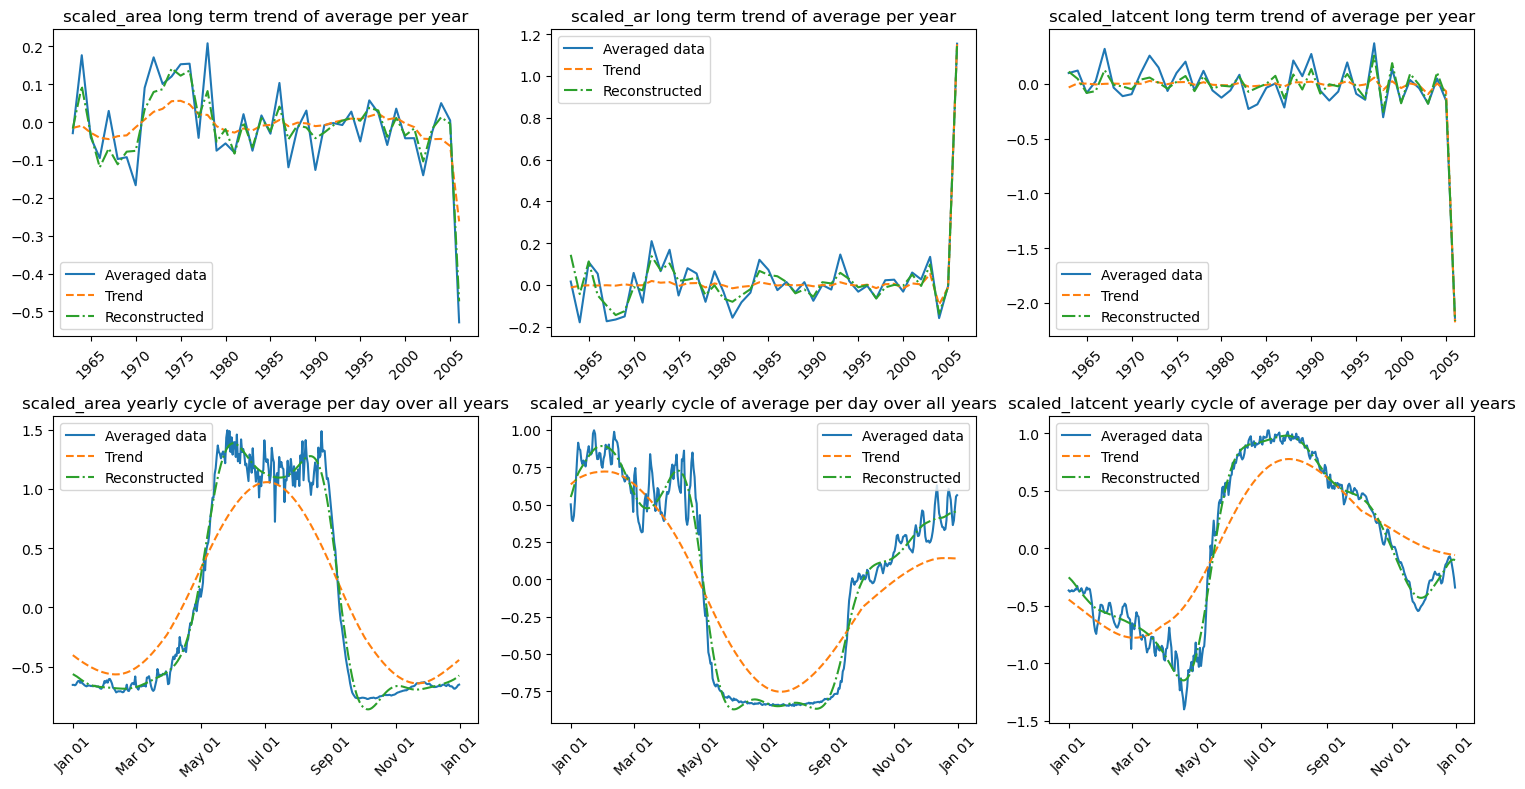

In [27]:
from vortexclust.workflows.demo import plot_ssa_grid

# Average data
avg_year = era5_all.groupby('year').mean()
avg_year.index = pd.to_datetime(avg_year.index, format='%Y')

avg_day_over_year = era5_all.groupby(['month', 'day']).mean()
avg_day_over_year.index = pd.to_datetime({"year": 2000,  # just a sample year, not displayed in plot
                                          "month": avg_day_over_year.index.get_level_values(0),
                                          "day": avg_day_over_year.index.get_level_values(1)})
# compute SSA
ssa_long_term = SingularSpectrumAnalysis(window_size=10)
ssa_yearly_cycle = SingularSpectrumAnalysis(window_size=90)

long_term_area = ssa_long_term.fit_transform(avg_year['scaled_area'].values.reshape(1, -1))
long_term_ar = ssa_long_term.fit_transform(avg_year['scaled_ar'].values.reshape(1, -1))
long_term_latcent = ssa_long_term.fit_transform(avg_year['scaled_latcent'].values.reshape(1, -1))

year_seasonality_area = ssa_yearly_cycle.fit_transform(avg_day_over_year['scaled_area'].values.reshape(1, -1))
year_seasonality_ar = ssa_yearly_cycle.fit_transform(avg_day_over_year['scaled_ar'].values.reshape(1, -1))
year_seasonality_latcent = ssa_yearly_cycle.fit_transform(avg_day_over_year['scaled_latcent'].values.reshape(1, -1))

# Plot SSA
plot_ssa_grid(
    data_series=[avg_year, avg_day_over_year],
    ssa_results=[[long_term_area, long_term_ar, long_term_latcent],
                 [year_seasonality_area, year_seasonality_ar, year_seasonality_latcent]],
    index_format=['%Y', '%b %d'],
    labels=['scaled_area', 'scaled_ar', 'scaled_latcent'],
    titles=['long term trend of average per year', 'yearly cycle of average per day over all years'],
    used_signals=4
)

## Abbreviations

|          |                                                 |
|---------:|:------------------------------------------------|
|      H11 | Hannachi et al. 2011                            |
|      IAP | Institute for Atmospheric Physics Kühlungsborn  |
|     DJFM | December, January, February, March              |
|       ar | Aspect ratio                                    |
|  latcent | centroid latitude                               |
|      SSW | Sudden Stratospheric Warming                    |
|        S | Cluster of split vortices                       |
|        D | Cluster of displaced vortices                   |
|        L | Cluster of large vortices                       |
|        U | Cluster of undisturbed vortices                 |
|      ACF | Autocorrelation function                        |
|     PACF | Partial Autocorrelation function                |